---

## 0. Descubrimiento de Esquemas de Tablas

Antes de cargar y analizar los datos, es una buena práctica consultar los esquemas de las tablas directamente en BigQuery para conocer las columnas disponibles y sus tipos de datos. Esto nos ayudará a evitar errores de `KeyError` y a comprender la estructura de cada conjunto de datos.

# Análisis Exploratorio de Datos (EDA) y Selección de Features

Este notebook de BigQuery te guiará a través de un Análisis Exploratorio de Datos (EDA) exhaustivo y un proceso de selección de features. Utilizaremos los conjuntos de datos proporcionados (`datawave-proyecto-final.census_dataset`, `datawave-proyecto-proyecto-final.gmaps_dataset`, y `datawave-proyecto-final.yelpdataset`) para entender sus características, identificar patrones y preparar los datos para el entrenamiento de un modelo. Al final, la justificación de la elección del modelo y los criterios de desarrollo se basarán en las insights obtenidas del EDA.

In [33]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURACIÓN GLOBAL ---
# Define la cantidad de filas a limitar en las consultas de BigQuery.
# Puedes cambiar este valor para cargar más o menos datos para tu EDA.
QUERY_LIMIT = 5000000

# Inicializa clientes de BigQuery para las ubicaciones correctas de tus datasets.
# 'US' es una ubicación multiregional que abarca varios datasets en Estados Unidos.
client_us = bigquery.Client(location='US')
# 'us-central1' es una región específica dentro de Estados Unidos, para el dataset de Yelp.
client_us_central = bigquery.Client(location='us-central1')

def print_table_schema(project_id, dataset_id, table_id, client_obj):
    """Consulta y muestra el esquema (columnas y tipos de datos) de una tabla de BigQuery.
       Recibe un objeto client_obj para manejar diferentes ubicaciones si es necesario."""
    query = f"""
    SELECT column_name, data_type
    FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.COLUMNS`
    WHERE table_name = '{table_id}'
    ORDER BY ordinal_position
    """
    print(f"\n--- Esquema para {dataset_id}.{table_id} (Ubicación del cliente: {client_obj.location}) ---")
    try:
        schema_df = client_obj.query(query).to_dataframe()
        if not schema_df.empty:
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                print(schema_df.to_string())
        else:
            print(f"No se encontraron columnas para la tabla '{table_id}'. Por favor, verifica el nombre o si es una tabla de datos real.")
    except Exception as e:
        print(f"Error al consultar el esquema: {e}")

# Consulta los esquemas de las tablas principales que usaremos
# Usa el cliente apropiado para cada dataset según las ubicaciones confirmadas

# Tablas del dataset de Censo (Ubicación: US)
print_table_schema('datawave-proyecto-final', 'census_dataset', 'Census', client_us)

# Tablas del dataset de Google Maps (Ubicación: US)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_attribute_relacional', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_attribute_types', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_attribute_values', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_category', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_category_relacional', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_hours', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_sites', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'review_gmap', client_us)

# Tablas del dataset de Yelp (Ubicación: us-central1)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'review_yelp', client_us)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'yelp_attributes', client_us)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'yelp_attributes_rel', client_us)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'yelp_business', client_us)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'yelp_category', client_us)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'yelp_category_rel', client_us)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'yelp_hours', client_us)


--- Esquema para census_dataset.Census (Ubicación del cliente: US) ---
               column_name data_type
0               state_fips     INT64
1              county_fips     INT64
2              county_name    STRING
3  median_household_income   FLOAT64
4        median_home_value   FLOAT64
5         total_population   FLOAT64

--- Esquema para gmaps_dataset.gmap_attribute_relacional (Ubicación del cliente: US) ---
          column_name data_type
0             gmap_id    STRING
1   attribute_type_id     INT64
2  attribute_value_id     INT64

--- Esquema para gmaps_dataset.gmap_attribute_types (Ubicación del cliente: US) ---
         column_name data_type
0     attribute_type    STRING
1  attribute_type_id     INT64

--- Esquema para gmaps_dataset.gmap_attribute_values (Ubicación del cliente: US) ---
          column_name data_type
0     attribute_value    STRING
1  attribute_value_id     INT64

--- Esquema para gmaps_dataset.gmap_category (Ubicación del cliente: US) ---
     column_n

---

## 1. Conexión a BigQuery y Carga de Datos

Ahora que conocemos los esquemas, cargaremos una muestra de los datos de cada tabla relevante en DataFrames de Pandas para facilitar el análisis. Recordamos que usamos `LIMIT` para una exploración inicial que no sobrecargue la memoria. El valor de `LIMIT` es controlado por la variable `QUERY_LIMIT` definida al inicio del script.

**Importante**: Estamos utilizando clientes de BigQuery con las ubicaciones correctas para cada dataset para asegurar el acceso.

In [34]:
# Inicializa clientes para las diferentes ubicaciones de tus datasets.
# La variable QUERY_LIMIT está definida globalmente al inicio del script.
client_us = bigquery.Client(location='US')
client_us_central = bigquery.Client(location='us-central1')

# Cargar datos del censo (usando client_us)
query_census = f"""
SELECT *
FROM `datawave-proyecto-final.census_dataset.Census`
LIMIT {QUERY_LIMIT}
"""
census_df = client_us.query(query_census).to_dataframe()

# Cargar datos de Google Maps: gmap_sites (información principal del negocio - usando client_us)
query_gmap_sites = f"""
SELECT *
FROM `datawave-proyecto-final.gmaps_dataset.gmap_sites`
WHERE REGEXP_EXTRACT(address, r',\\s*([A-Z]{{2}})\\s+\\d{{5}},\\s*United States') = 'NJ'
LIMIT {QUERY_LIMIT}
"""
gmap_sites_df = client_us.query(query_gmap_sites).to_dataframe()

# Cargar datos de Google Maps: review_gmap (reseñas de clientes - usando client_us)
query_review_gmap = f"""
SELECT r.*
FROM `datawave-proyecto-final.gmaps_dataset.review_gmap` r
JOIN `datawave-proyecto-final.gmaps_dataset.gmap_sites` s
  ON r.gmap_id = s.gmap_id
WHERE REGEXP_EXTRACT(s.address, r',\\s*([A-Z]{{2}})\\s+\\d{{5}},\\s*United States') = 'NJ'
LIMIT {QUERY_LIMIT}
"""
review_gmap_df = client_us.query(query_review_gmap).to_dataframe()

# Cargar datos de Google Maps: gmap_attribute_relacional (atributos de negocios - usando client_us)
query_gmap_attributes = f"""
SELECT a.*
FROM `datawave-proyecto-final.gmaps_dataset.gmap_attribute_relacional` a
JOIN `datawave-proyecto-final.gmaps_dataset.gmap_sites` s
  ON a.gmap_id = s.gmap_id
WHERE REGEXP_EXTRACT(s.address, r',\s*([A-Z]{2})\s+\d{5},\s*United States') = 'NJ'
LIMIT {QUERY_LIMIT}
"""
gmap_attributes_df = client_us.query(query_gmap_attributes).to_dataframe()

# Cargar datos de Google Maps: gmap_category_relacional (categorías de negocios - usando client_us)
query_gmap_categories = f"""
SELECT c.*
FROM `datawave-proyecto-final.gmaps_dataset.gmap_category_relacional` c
JOIN `datawave-proyecto-final.gmaps_dataset.gmap_sites` s
  ON c.gmap_id = s.gmap_id
WHERE REGEXP_EXTRACT(s.address, r',\s*([A-Z]{2})\s+\d{5},\s*United States') = 'NJ'
LIMIT {QUERY_LIMIT}
"""
gmap_categories_df = client_us.query(query_gmap_categories).to_dataframe()

# Cargar datos de Yelp: yelp_business (información principal del negocio - usando client_us)
query_yelp_business = f"""
SELECT *
FROM `datawave-proyecto-final.yelpdataset.yelp_business`
WHERE LOWER(state) = 'nj'
LIMIT {QUERY_LIMIT}
"""
yelp_business_df = client_us.query(query_yelp_business).to_dataframe()

# Cargar datos de Yelp: review_yelp (reseñas de clientes - usando client_us)
query_review_yelp = f"""
SELECT r.*
FROM `datawave-proyecto-final.yelpdataset.review_yelp` r
JOIN `datawave-proyecto-final.yelpdataset.yelp_business` b
  ON r.business_id = b.business_id
WHERE LOWER(b.state) = 'nj'
LIMIT {QUERY_LIMIT}
"""
review_yelp_df = client_us.query(query_review_yelp).to_dataframe()

# Cargar datos de Yelp: yelp_attributes_rel (atributos de negocios - usando client_us)
query_yelp_attributes_rel = f"""
SELECT a.*
FROM `datawave-proyecto-final.yelpdataset.yelp_attributes_rel` a
JOIN `datawave-proyecto-final.yelpdataset.yelp_business` b
  ON a.business_id = b.business_id
WHERE LOWER(b.state) = 'nj'
LIMIT {QUERY_LIMIT}
"""
yelp_attributes_rel_df = client_us.query(query_yelp_attributes_rel).to_dataframe()

# Cargar datos de Yelp: yelp_category_rel (categorías de negocios - usando client_us)
query_yelp_category_rel = f"""
SELECT *
FROM `datawave-proyecto-final.yelpdataset.yelp_category_rel`
LIMIT {QUERY_LIMIT}
"""
yelp_category_rel_df = client_us.query(query_yelp_category_rel).to_dataframe()

---

## 2. Análisis Exploratorio de Datos (EDA)

Realizaremos un EDA para cada conjunto de datos, inspeccionando su estructura, identificando valores faltantes, analizando distribuciones y explorando relaciones entre variables.

### 2.1. `census_dataset.Census`

Este conjunto de datos contiene información demográfica a nivel de condado.

--- census_df ---
Primeras 5 filas:
   state_fips  county_fips                    county_name  \
0          34            1    Atlantic County, New Jersey   
1          34            3      Bergen County, New Jersey   
2          34            5  Burlington County, New Jersey   
3          34            7      Camden County, New Jersey   
4          34            9    Cape May County, New Jersey   

   median_household_income  median_home_value  total_population  
0                  76819.0           272700.0          274704.0  
1                 123715.0           593200.0          954717.0  
2                 105271.0           326700.0          464226.0  
3                  86384.0           262200.0          524042.0  
4                  88046.0           395000.0           95236.0  

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------      

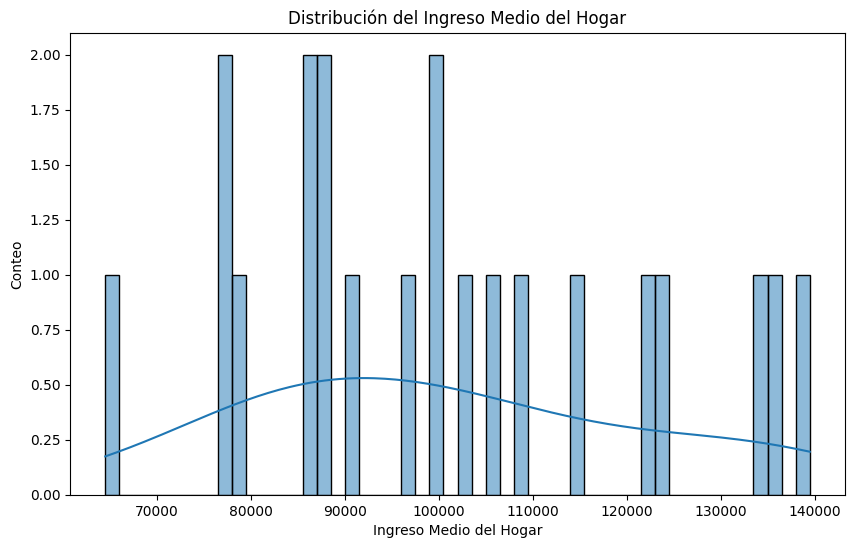

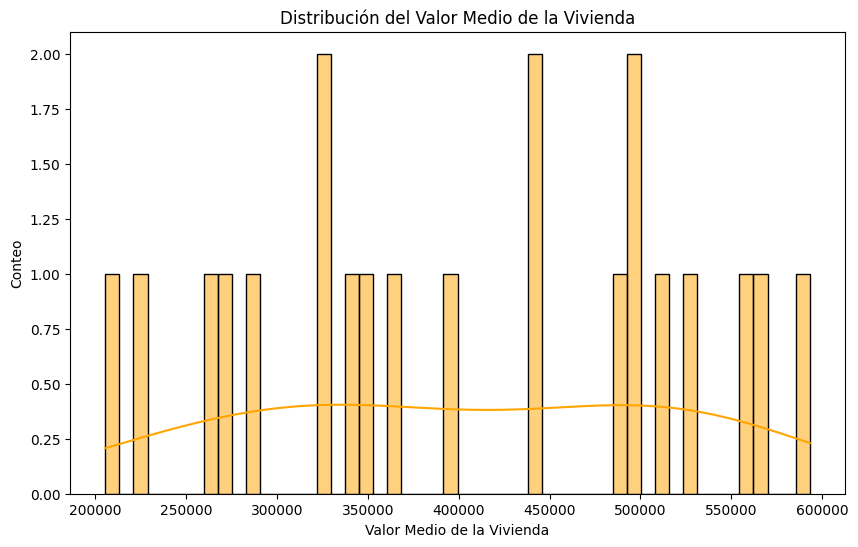

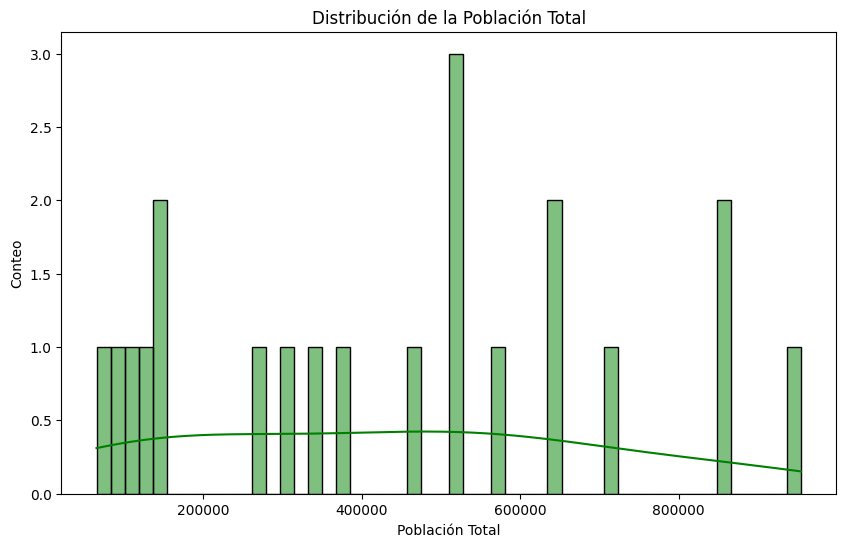

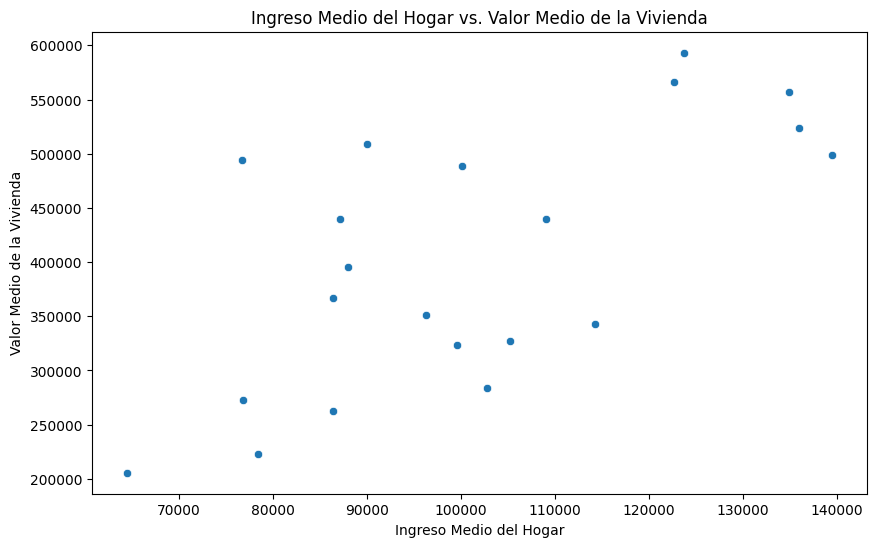

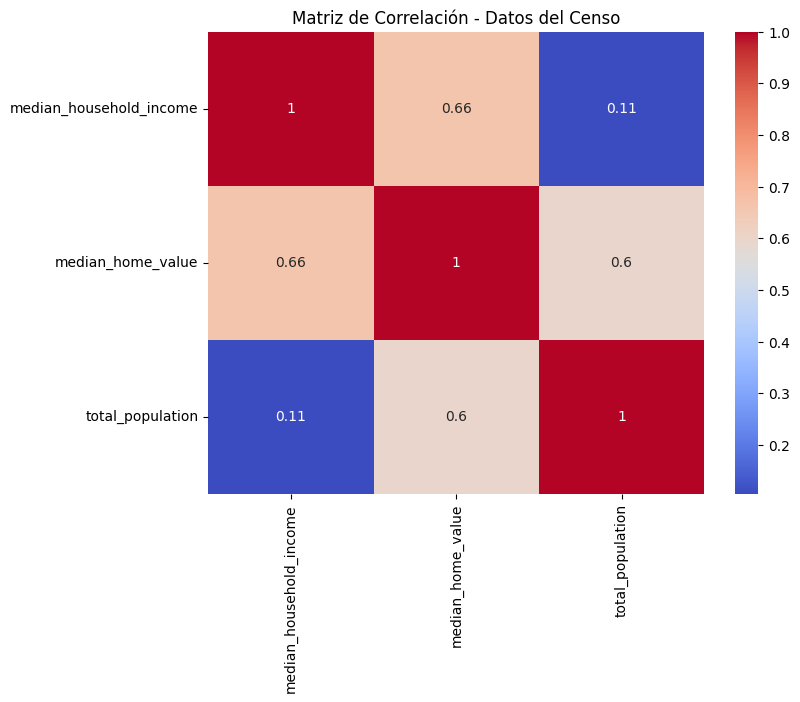

In [35]:
print("--- census_df ---")
print("Primeras 5 filas:")
print(census_df.head())
print("\nInformación del DataFrame:")
print(census_df.info())
print("\nEstadísticas descriptivas:")
print(census_df.describe())
print("\nConteo de valores nulos:")
print(census_df.isnull().sum())

# Visualizar la distribución del ingreso medio del hogar
plt.figure(figsize=(10, 6))
sns.histplot(census_df['median_household_income'], bins=50, kde=True)
plt.title('Distribución del Ingreso Medio del Hogar')
plt.xlabel('Ingreso Medio del Hogar')
plt.ylabel('Conteo')
plt.show()

# Visualizar la distribución del valor medio de la vivienda
plt.figure(figsize=(10, 6))
sns.histplot(census_df['median_home_value'], bins=50, kde=True, color='orange')
plt.title('Distribución del Valor Medio de la Vivienda')
plt.xlabel('Valor Medio de la Vivienda')
plt.ylabel('Conteo')
plt.show()

# Visualizar la distribución de la población total
plt.figure(figsize=(10, 6))
sns.histplot(census_df['total_population'], bins=50, kde=True, color='green')
plt.title('Distribución de la Población Total')
plt.xlabel('Población Total')
plt.ylabel('Conteo')
plt.show()

# Relación entre ingreso medio del hogar y valor medio de la vivienda
plt.figure(figsize=(10, 6))
sns.scatterplot(x='median_household_income', y='median_home_value', data=census_df)
plt.title('Ingreso Medio del Hogar vs. Valor Medio de la Vivienda')
plt.xlabel('Ingreso Medio del Hogar')
plt.ylabel('Valor Medio de la Vivienda')
plt.show()

# Matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(census_df[['median_household_income', 'median_home_value', 'total_population']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación - Datos del Censo')
plt.show()

**Análisis de `census_df`:**
* **`state_fips`** y **`county_fips`**: Son identificadores. `state_fips` parece constante (34, New Jersey), lo que significa que el análisis es a nivel de condado dentro de ese estado. `county_fips` es el identificador único del condado.
* **`county_name`**: Nombre del condado.
* **`median_household_income`**: Variable numérica clave. Su distribución es importante para entender la riqueza de los condados.
* **`median_home_value`**: Otra variable numérica clave, a menudo correlacionada con el ingreso.
* **`total_population`**: Muestra la densidad demográfica.
* **Valores Nulos**: En este dataset de ejemplo, no hay valores nulos, lo que es ideal.
* **Correlaciones**: Se observará la relación entre ingreso, valor de la vivienda y población para entender los factores socioeconómicos.

---

### 2.2. `gmaps_dataset`

Este conjunto de datos abarca información de negocios de Google Maps, incluyendo sitios, reseñas, atributos y categorías.

#### 2.2.1. `gmap_sites_df` (Información principal del negocio)


--- gmap_sites_df ---
Primeras 5 filas:
                                             address  avg_rating  \
0  Blue Cross and Blue Shield, 1427 Wyckoff Rd, W...         1.7   
1  Domino's Pizza, 190 Kearny Ave, Kearny, NJ 070...         3.6   
2  Blimpie America's Sub Shop, 18 S Valley Rd, We...         3.7   
3  BJ's Wholesale Club, 1601 US-22, Watchung, NJ ...         3.7   
4  San Antonio, 206 Monroe St, Passaic, NJ 07055,...         3.8   

                                         description  \
0                                               None   
1  Delivery/carryout chain offering a wide range ...   
2  This counter-serve sandwich chain offers hot, ...   
3  Membership-only retail chain offering bulk gro...   
4                                               None   

                                 gmap_id   latitude  longitude  \
0  0x89c22a28599003e7:0xd907ff9b4b23e398  40.209343 -74.130722   
1  0x89c2546a238e5cab:0x1ce865ccf46913ca  40.757703 -74.152780   
2  0x89c3ab6e44

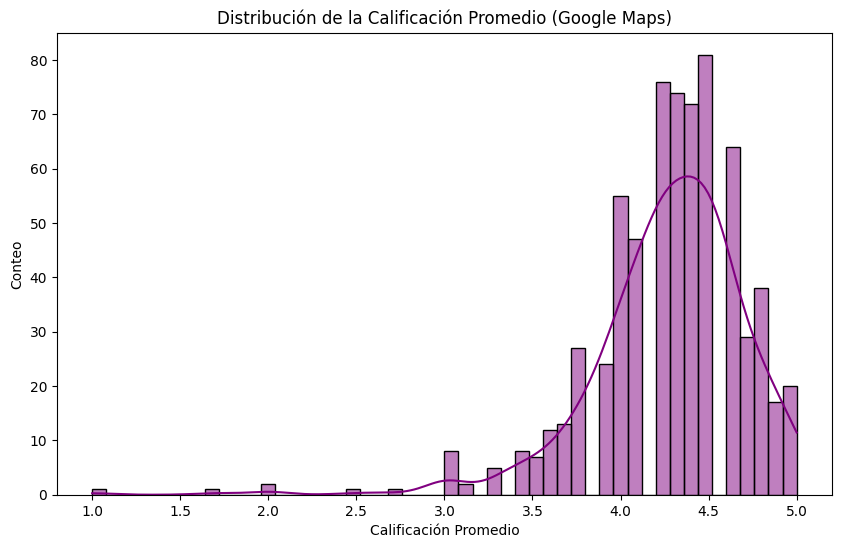

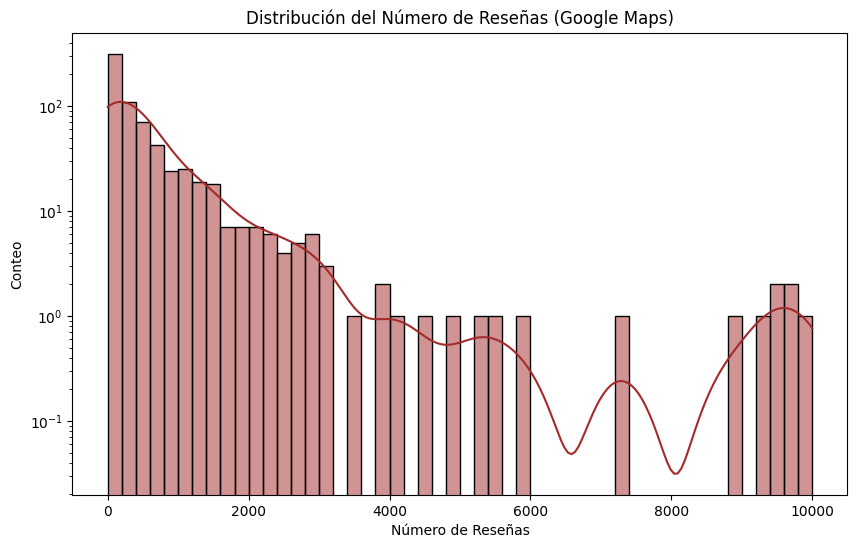

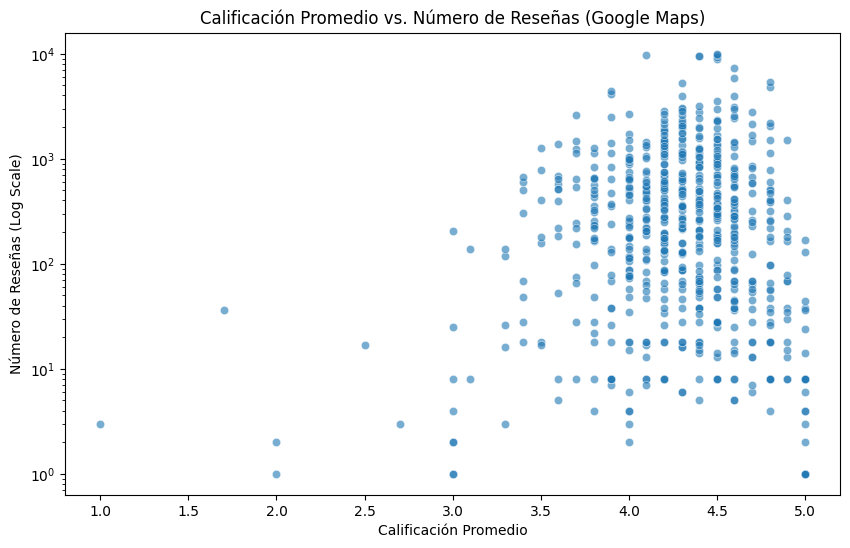

In [36]:
print("\n--- gmap_sites_df ---")
print("Primeras 5 filas:")
print(gmap_sites_df.head())
print("\nInformación del DataFrame:")
print(gmap_sites_df.info())
print("\nEstadísticas descriptivas:")
print(gmap_sites_df.describe())
print("\nConteo de valores nulos:")
print(gmap_sites_df.isnull().sum())

# Distribución de la calificación promedio (avg_rating)
plt.figure(figsize=(10, 6))
sns.histplot(gmap_sites_df['avg_rating'], bins=50, kde=True, color='purple')
plt.title('Distribución de la Calificación Promedio (Google Maps)')
plt.xlabel('Calificación Promedio')
plt.ylabel('Conteo')
plt.show()

# Distribución del número de reseñas (num_of_reviews)
plt.figure(figsize=(10, 6))
sns.histplot(gmap_sites_df['num_of_reviews'], bins=50, kde=True, color='brown')
plt.title('Distribución del Número de Reseñas (Google Maps)')
plt.xlabel('Número de Reseñas')
plt.ylabel('Conteo')
plt.yscale('log') # Usar escala logarítmica para ver la distribución de valores bajos
plt.show()

# Relación entre calificación promedio y número de reseñas
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_rating', y='num_of_reviews', data=gmap_sites_df, alpha=0.6)
plt.title('Calificación Promedio vs. Número de Reseñas (Google Maps)')
plt.xlabel('Calificación Promedio')
plt.ylabel('Número de Reseñas (Log Scale)')
plt.yscale('log')
plt.show()

**Análisis de `gmap_sites_df`:**
* **`gmap_id`**: Identificador único del negocio en Google Maps.
* **`name`**: Nombre del negocio.
* **`address`, `state`, `zip_code`**: Información de ubicación. Evaluar la completitud de estos datos.
* **`avg_rating`**: Variable numérica clave, likely skewed towards higher ratings.
* **`num_of_reviews`**: Otra variable numérica clave, que probablemente esté muy sesgada (muchos negocios con pocas reseñas, pocos con muchas). Podría requerir transformación logarítmica.
* **Valores Nulos**: Identificar qué columnas tienen valores nulos y planificar su manejo (imputación, eliminación).
* **Relación Rating vs. Reviews**: Ver si los negocios con mejores calificaciones tienden a tener más reseñas y viceversa.

---

#### 2.2.2. `review_gmap_df` (Reseñas de clientes)


--- review_gmap_df ---
Primeras 5 filas:
   review_id  text  rating                 user_id  \
0   10212006  None       4  1.0877908051438325e+20   
1   10205914  None       4  1.0608811953449578e+20   
2   10210843  None       4   1.146935889554338e+20   
3   10205875  None       4  1.1532668305493095e+20   
4   10212679  None       4  1.1333392094083128e+20   

                                 gmap_id                        date_time  \
0   0x89c134d5e9bba45f:0x2c113c8f0a877e6 2020-12-13 01:33:28.967000+00:00   
1  0x89c2516c60406dc7:0xff6c14336f717b2f 2018-09-17 20:49:07.993000+00:00   
2  0x89c253906d25596f:0xe7435039ef0abb10 2019-07-21 22:30:49.738000+00:00   
3  0x89c477a4860d2511:0xcd0191122babbbc6 2019-11-07 11:26:34.252000+00:00   
4  0x89c6cbfa6b96e289:0xd405a42fdf8e139f 2017-06-21 16:29:42.689000+00:00   

   sentiment_score sentiment_label  
0              0.0         neutral  
1              0.0         neutral  
2              0.0         neutral  
3              0.0    

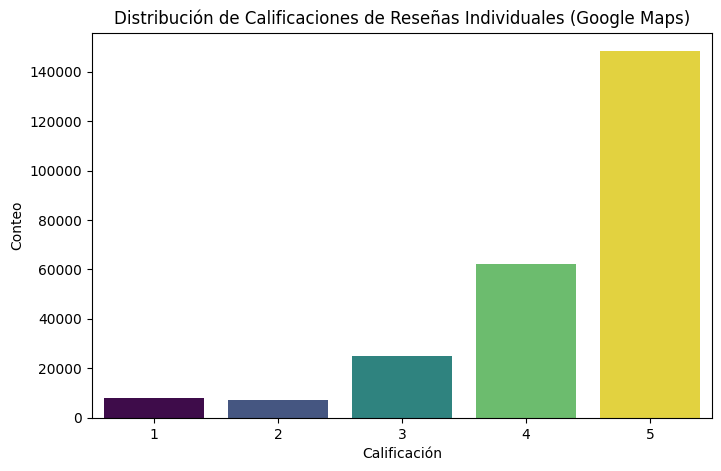

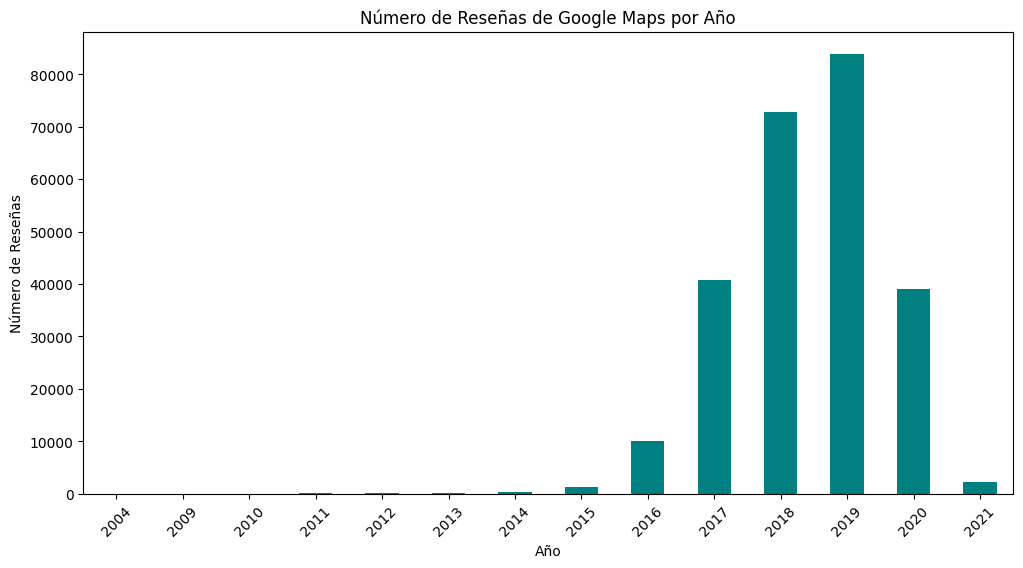

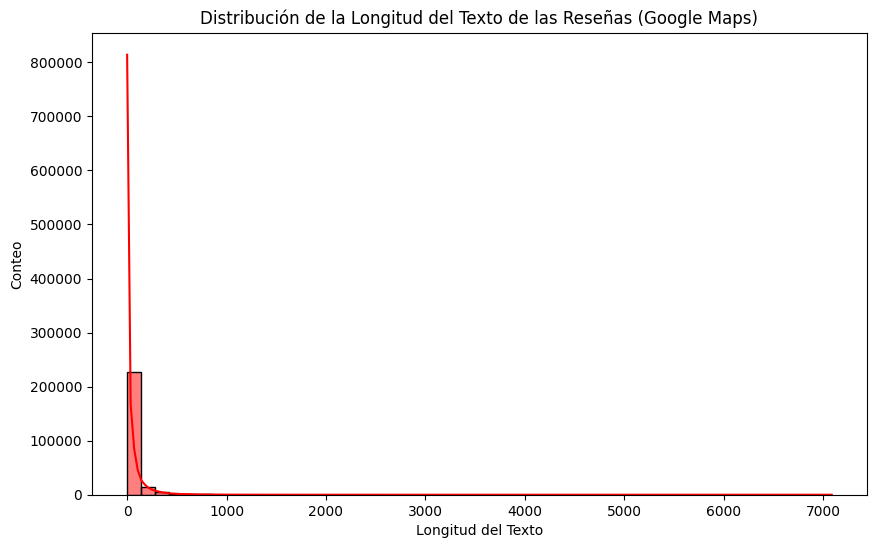

In [37]:
print("\n--- review_gmap_df ---")
print("Primeras 5 filas:")
print(review_gmap_df.head())
print("\nInformación del DataFrame:")
print(review_gmap_df.info())
print("\nEstadísticas descriptivas:")
print(review_gmap_df.describe())
print("\nConteo de valores nulos:")
print(review_gmap_df.isnull().sum())

# Distribución de las calificaciones de las reseñas individuales (rating)
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=review_gmap_df, palette='viridis', hue='rating', legend=False)
plt.title('Distribución de Calificaciones de Reseñas Individuales (Google Maps)')
plt.xlabel('Calificación')
plt.ylabel('Conteo')
plt.show()

# Conversión de la columna 'date' a formato datetime
review_gmap_df['date'] = pd.to_datetime(review_gmap_df['date_time'], errors='coerce')

# Análisis temporal de las reseñas (por año)
plt.figure(figsize=(12, 6))
review_gmap_df['date'].dt.year.value_counts().sort_index().plot(kind='bar', color='teal')
plt.title('Número de Reseñas de Google Maps por Año')
plt.xlabel('Año')
plt.ylabel('Número de Reseñas')
plt.xticks(rotation=45)
plt.show()

# Longitud del texto de las reseñas
review_gmap_df['text_length'] = review_gmap_df['text'].fillna('').apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(review_gmap_df['text_length'], bins=50, kde=True, color='red')
plt.title('Distribución de la Longitud del Texto de las Reseñas (Google Maps)')
plt.xlabel('Longitud del Texto')
plt.ylabel('Conteo')
plt.show()

**Análisis de `review_gmap_df`:**
* **`review_id`, `gmap_id`, `user_id`**: Identificadores.
* **`rating`**: Calificación individual de la reseña. Probablemente muy sesgada hacia 5 estrellas.
* **`text`**: El contenido de la reseña. Útil para análisis de texto (sentimiento, palabras clave).
* **`time`**: Columna de tiempo, que ahora convertimos a `date`.
* **Valores Nulos**: Prestar atención a los `text` nulos.
* **Insights**: ¿La mayoría de las reseñas son positivas? ¿Hay tendencias en el tiempo? ¿Las reseñas más largas tienen calificaciones diferentes?

#### 2.2.3. Tablas relacionales y de atributos de Google Maps

Estas tablas requieren **uniones (joins)** para ser útiles.


--- gmap_sites_categories_df (Ejemplo de JOIN) ---
                                             address  \
0  Ricky's Toledo Towing Service | 24-Hour Roadsi...   
1            CVS, 1905 US-6, Carmel Hamlet, NY 10512   
2  The UPS Store, 398 W Army Trail Rd #124, Bloom...   
3  PostalAnnex+, 2658 Del Mar Heights Rd, Del Mar...   
4  PostalAnnex+, 2658 Del Mar Heights Rd, Del Mar...   

                                 gmap_id  \
0  0x80c2c663fbfa524b:0xf691797e079297cd   
1  0x89dd4d79f017cb9f:0xc48b42987559d179   
2  0x880fab7a207565db:0x5e45dcbb4481d639   
3  0x80dc08a10c8f272b:0xddc2c5e0f42649b7   
4  0x80dc08a10c8f272b:0xddc2c5e0f42649b7   

                                                name  avg_rating  \
0  Ricky's Toledo Towing Service | 24-Hour Roadsi...         1.9   
1                                                CVS         2.1   
2                                      The UPS Store         2.3   
3                                       PostalAnnex+         2.4   
4     

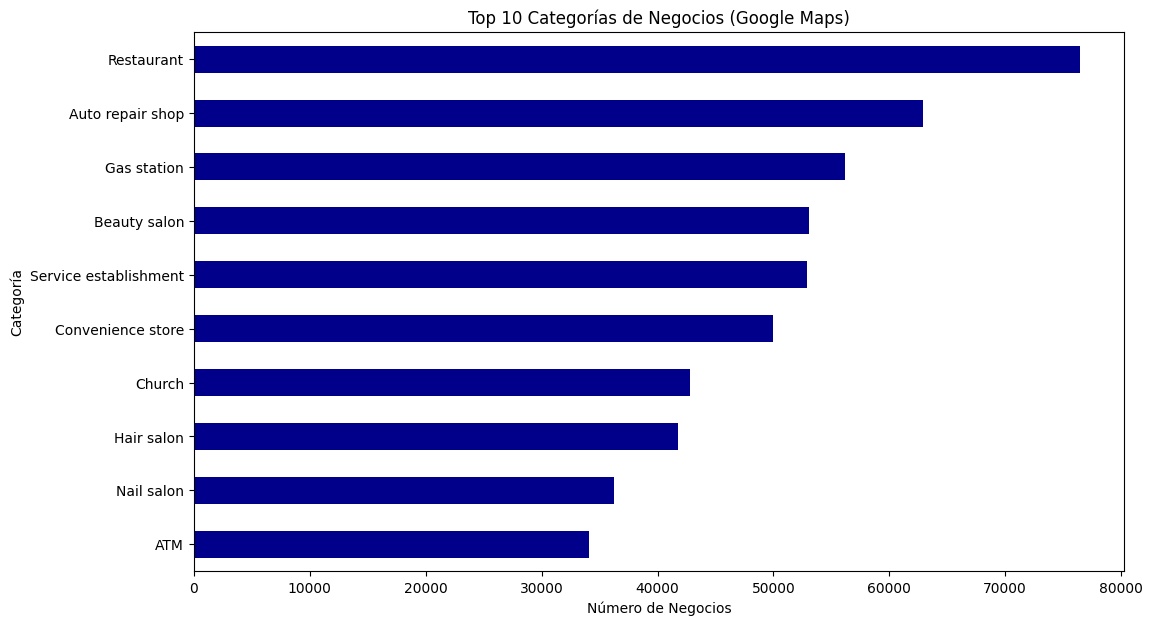

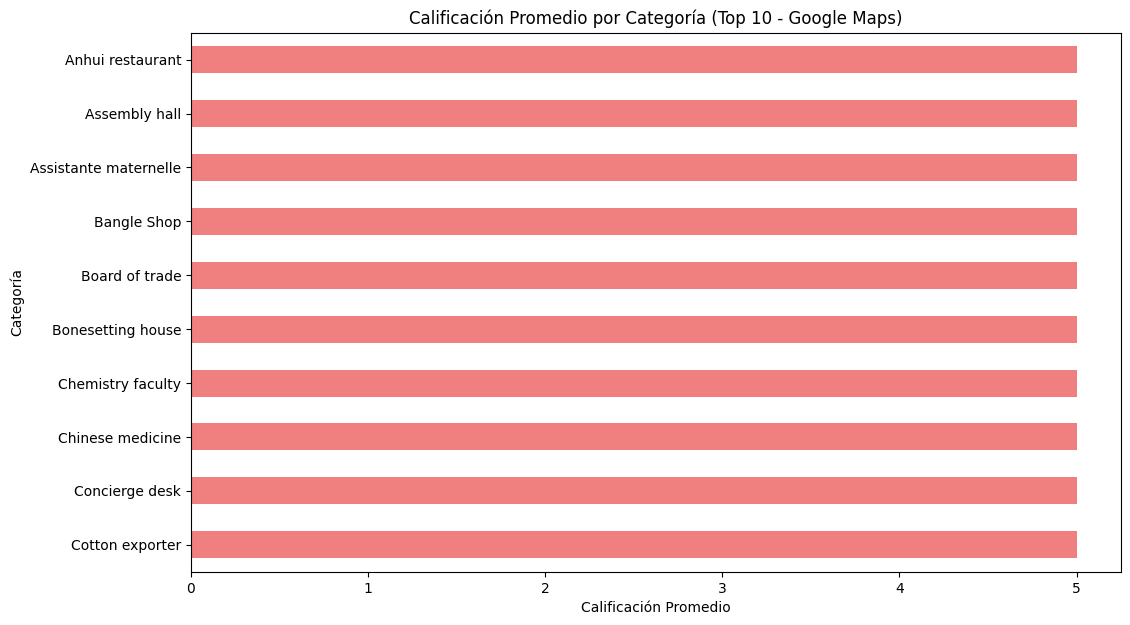

In [38]:
# Ejemplo de unión: gmap_sites con gmap_category_relacional y gmap_category
# Para ver las categorías de los negocios
query_gmap_sites_categories = f"""
SELECT
    s.address,
    s.gmap_id,
    s.name,
    s.avg_rating,
    c.category_name
FROM
    `datawave-proyecto-final.gmaps_dataset.gmap_sites` AS s
JOIN
    `datawave-proyecto-final.gmaps_dataset.gmap_category_relacional` AS scr ON s.gmap_id = scr.gmap_id
JOIN
    `datawave-proyecto-final.gmaps_dataset.gmap_category` AS c ON scr.category_id = c.category_id
LIMIT {QUERY_LIMIT}
"""
gmap_sites_categories_df = client_us.query(query_gmap_sites_categories).to_dataframe()

print("\n--- gmap_sites_categories_df (Ejemplo de JOIN) ---")
print(gmap_sites_categories_df.head())
print(gmap_sites_categories_df.info())

# Top 10 categorías de negocios
plt.figure(figsize=(12, 7))
gmap_sites_categories_df['category_name'].value_counts().head(10).plot(kind='barh', color='darkblue')
plt.title('Top 10 Categorías de Negocios (Google Maps)')
plt.xlabel('Número de Negocios')
plt.ylabel('Categoría')
plt.gca().invert_yaxis() # Para que la categoría más frecuente esté arriba
plt.show()

# Calificación promedio por categoría (Top 10)
avg_rating_by_category = gmap_sites_categories_df.groupby('category_name')['avg_rating'].mean().nlargest(10)
plt.figure(figsize=(12, 7))
avg_rating_by_category.plot(kind='barh', color='lightcoral')
plt.title('Calificación Promedio por Categoría (Top 10 - Google Maps)')
plt.xlabel('Calificación Promedio')
plt.ylabel('Categoría')
plt.gca().invert_yaxis()
plt.show()

**Análisis de tablas relacionales de Google Maps:**
* **`gmap_attribute_relacional`, `gmap_attribute_types`, `gmap_attribute_values`**: Permiten entender los atributos específicos de los negocios (e.g., "apto para niños", "tiene Wi-Fi"). Se analizará la frecuencia de estos atributos y su relación con las calificaciones/reseñas.
* **`gmap_category_relacional`, `gmap_category`**: Esencial para categorizar los negocios y entender las diferencias de rendimiento entre tipos de establecimientos.
* **Tablas de Cocinas Específicas (`Asian_Cuisine_Google`, etc.)**: Estas tablas NO EXISTEN como tablas independientes en este dataset, sino que serían el resultado de filtrar `gmap_sites` por categoría. El análisis de rendimiento por tipo de cocina se realizará a través de uniones y filtros.
* **`gmap_hours`**: Permite entender los patrones de horario de atención y cómo esto podría afectar la popularidad de un negocio.

---

### 2.3. `yelp_dataset`

Este conjunto de datos es similar al de Google Maps pero con su propia estructura y atributos únicos.

#### 2.3.1. `yelp_business_df` (Información principal del negocio)

Inspeccionaremos las columnas disponibles para los negocios de Yelp.


--- yelp_business_df ---
Primeras 5 filas:
              business_id            name           address      city state  \
0  rkqsFfbdeuXevR4Z3VgFuA      McDonald's  1663 Old York Rd  Abington    NJ   
1  Thavh5iKWC0KYhYp5dEWeQ         TJ Maxx  1495 Old York Rd  Abington    NJ   
2  71142Ice897c19VUQmVFLg  Abington Nails  1423 Old York Rd  Abington    NJ   
3  xU04OJtdN9XFmicHziwU9A    Blinds To Go  1936 Old York Rd  Abington    NJ   
4  -lM78iJEh0GH5MkgE-_u5g    Jimmy John's  1140 Old York Rd  Abington    NJ   

  postal_code   latitude  longitude  stars  review_count  __index_level_0__  
0       19001  40.131196 -75.115782    1.5            84             139609  
1       19001  40.125300 -75.115679    2.5            20              45445  
2       19001  40.122939 -75.116085    2.5            47             120410  
3       19001  40.138626 -75.113284    2.5            15             146367  
4       19001  40.115986 -75.121391    3.0            17              51919  

Información 

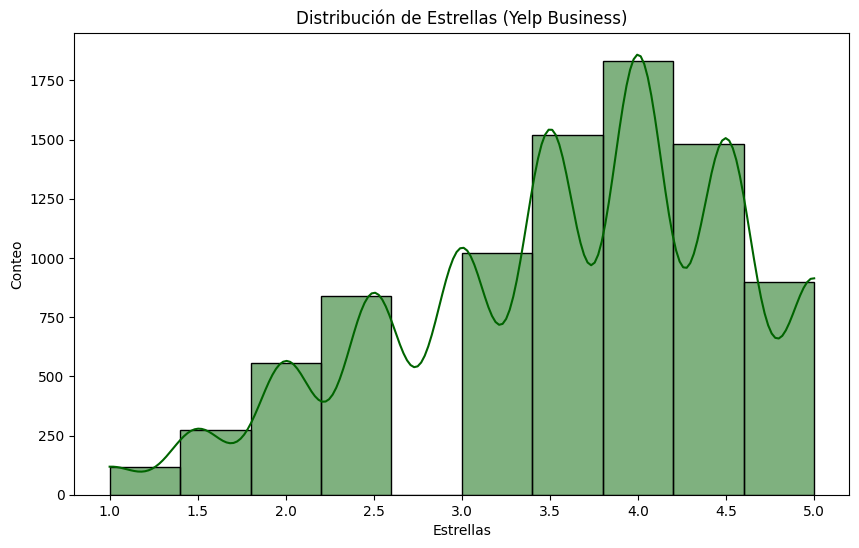

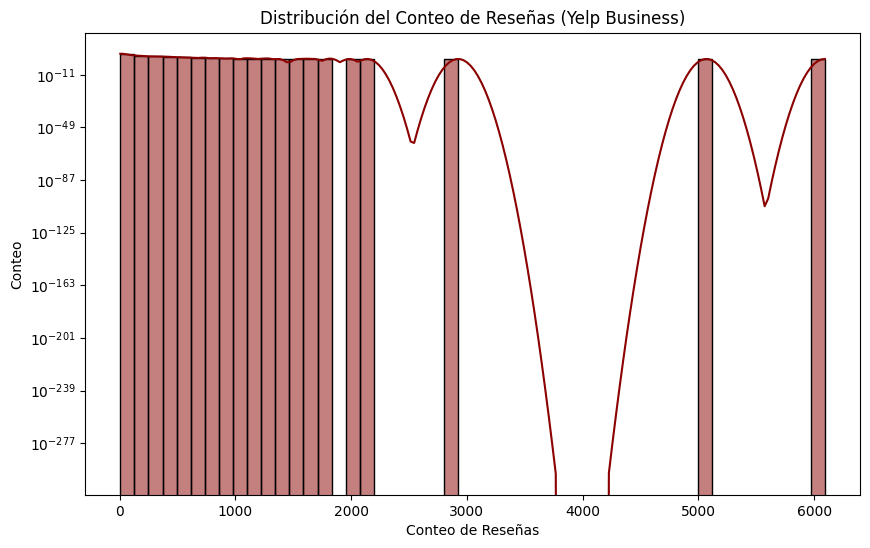

In [39]:
print("\n--- yelp_business_df ---")
print("Primeras 5 filas:")
print(yelp_business_df.head())
print("\nInformación del DataFrame:")
print(yelp_business_df.info())
print("\nEstadísticas descriptivas:")
print(yelp_business_df.describe())
print("\nConteo de valores nulos:")
print(yelp_business_df.isnull().sum())

# Distribución de las estrellas (calificación) de Yelp
plt.figure(figsize=(10, 6))
sns.histplot(yelp_business_df['stars'], bins=10, kde=True, color='darkgreen')
plt.title('Distribución de Estrellas (Yelp Business)')
plt.xlabel('Estrellas')
plt.ylabel('Conteo')
plt.show()

# Distribución del conteo de reseñas (review_count)
plt.figure(figsize=(10, 6))
sns.histplot(yelp_business_df['review_count'], bins=50, kde=True, color='darkred')
plt.title('Distribución del Conteo de Reseñas (Yelp Business)')
plt.xlabel('Conteo de Reseñas')
plt.ylabel('Conteo')
plt.yscale('log') # Usar escala logarítmica
plt.show()

**Análisis de `yelp_business_df`:**
* **`business_id`**: Identificador único del negocio en Yelp.
* **`stars`**: Calificación promedio del negocio en Yelp (similar a `avg_rating` en Google Maps).
* **`review_count`**: Número total de reseñas.
* **`address`, `city`, `state`, `postal_code`**: Información de ubicación.
* **Valores Nulos**: Identificar y manejar.
* **Consideración de 'éxito'**: Como la columna `is_open` no está presente en el esquema de la tabla `yelp_business` en BigQuery, el "éxito" del negocio deberá definirse a partir de otras métricas como `stars` y `review_count`.

#### 2.3.2. `review_yelp_df` (Reseñas de clientes)


--- review_yelp_df ---
Primeras 5 filas:
                review_id                 user_id             business_id  \
0  2uWq21Bq3j9RMDna0W_QWA  y-FlbbTzdRRdUwJpAiJfJg  q-6zZAqF4ARfw05oZUXnLQ   
1  BsFFwGB_4rkH1luaMjtAyQ  KrZP9pKVlV_kecf3XPDhAw  7w1kfRXe_OYTvWU2NHE8QQ   
2  gXFQCwCZE_kX8VmgU36gXg  hSbCSR7F8HAwfoZcm0jpww  YWfOxkw6ZqMOsVm3hsv2ig   
3  ClRAwes00js2yf9Tl8sM6A  NQ3ODjQuivlZT4P_GLhe9A  UQZ4p6xb_7gY7UXHmBzceg   
4  dulp5MXN_OARNuYNhy7oPA  miu-fYbZDHC1Ue5fTlXPSA  0wHUCfnfSzTdtwlTTAPoKA   

                       date  stars  \
0 2012-05-17 22:09:41+00:00    1.0   
1 2015-09-16 06:15:13+00:00    1.0   
2 2017-04-10 14:47:37+00:00    1.0   
3 2016-04-23 23:08:54+00:00    1.0   
4 2016-07-15 20:16:05+00:00    1.0   

                                                text  useful  funny  cool  
0  If I could give them 0 stars I would. I just h...       5      1     1  
1  Stopped by for lunch today around 12:30pm. The...       0      1     0  
2  I would not recommend this place. T

<ipython-input-40-390de61c0f40>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stars', data=review_yelp_df, palette='cividis')


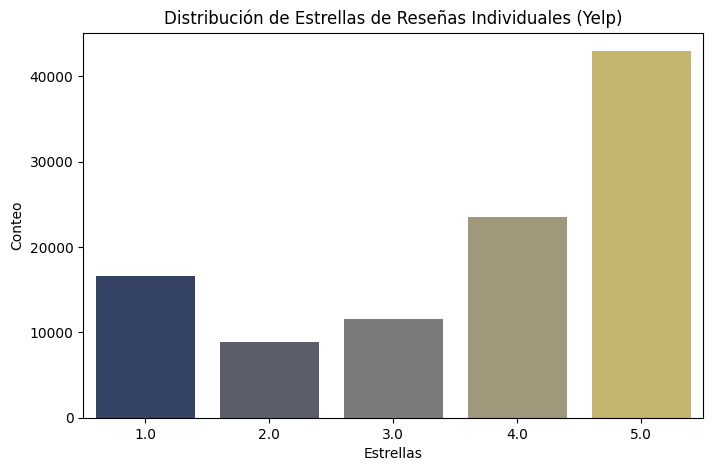

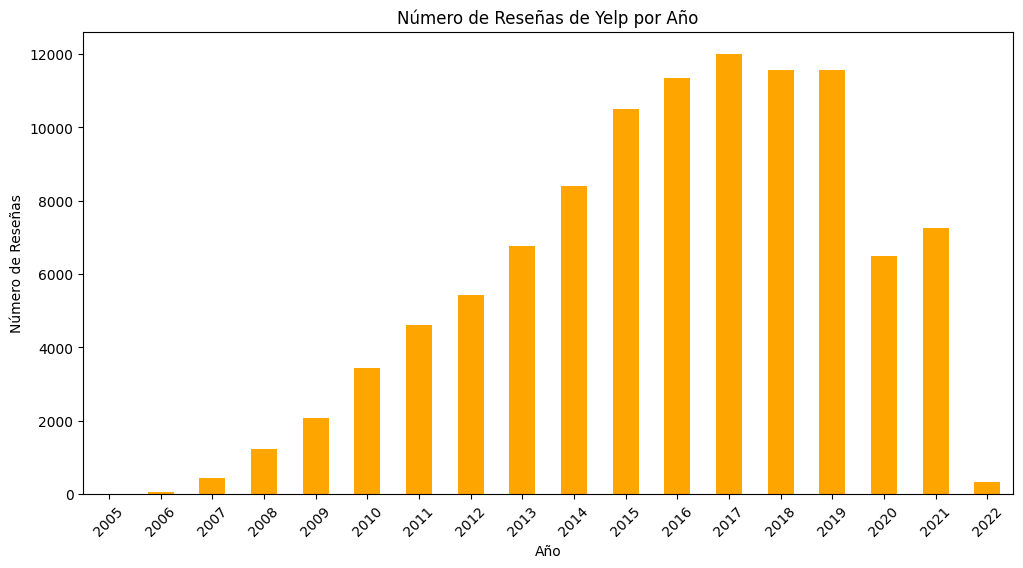

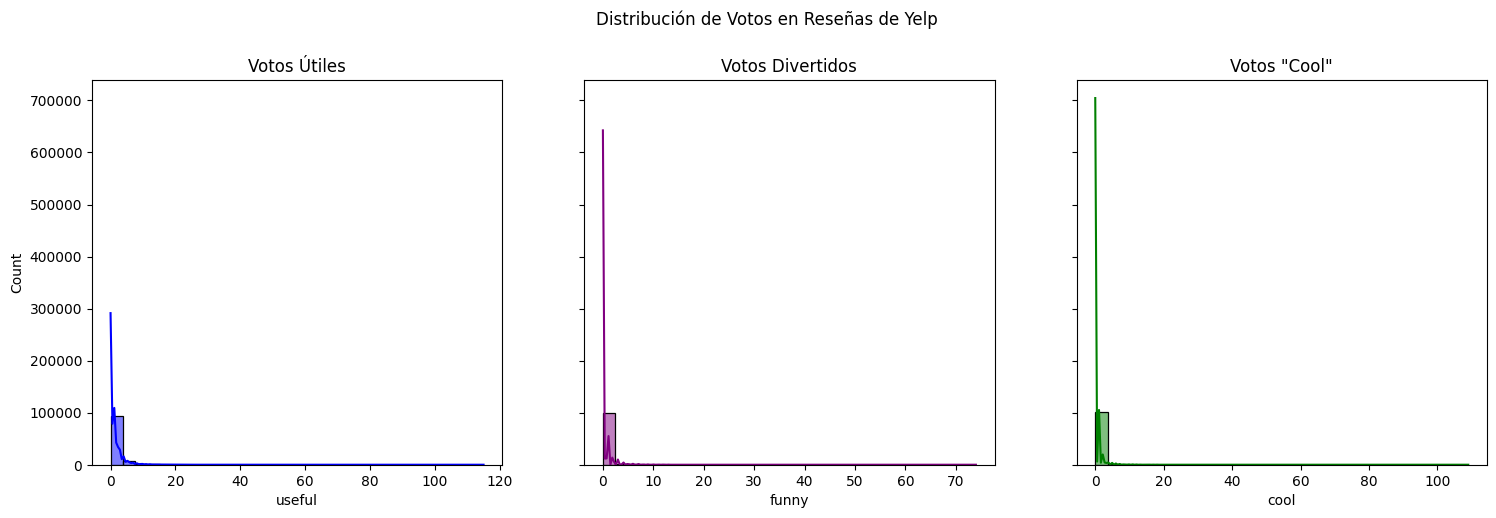

In [40]:
print("\n--- review_yelp_df ---")
print("Primeras 5 filas:")
print(review_yelp_df.head())
print("\nInformación del DataFrame:")
print(review_yelp_df.info())
print("\nEstadísticas descriptivas:")
print(review_yelp_df.describe())
print("\nConteo de valores nulos:")
print(review_yelp_df.isnull().sum())

# Distribución de las estrellas de las reseñas individuales
plt.figure(figsize=(8, 5))
sns.countplot(x='stars', data=review_yelp_df, palette='cividis')
plt.title('Distribución de Estrellas de Reseñas Individuales (Yelp)')
plt.xlabel('Estrellas')
plt.ylabel('Conteo')
plt.show()

# Conversión de la columna 'date' a formato datetime
review_yelp_df['date'] = pd.to_datetime(review_yelp_df['date'], errors='coerce')
# Análisis temporal de las reseñas (por año)
plt.figure(figsize=(12, 6))
review_yelp_df['date'].dt.year.value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('Número de Reseñas de Yelp por Año')
plt.xlabel('Año')
plt.ylabel('Número de Reseñas')
plt.xticks(rotation=45)
plt.show()

# Distribución de votos 'useful', 'funny', 'cool'
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
sns.histplot(review_yelp_df['useful'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Votos Útiles')
sns.histplot(review_yelp_df['funny'], bins=30, kde=True, ax=axes[1], color='purple')
axes[1].set_title('Votos Divertidos')
sns.histplot(review_yelp_df['cool'], bins=30, kde=True, ax=axes[2], color='green')
axes[2].set_title('Votos "Cool"')
plt.suptitle('Distribución de Votos en Reseñas de Yelp', y=1.02)
plt.show()

**Análisis de `review_yelp_df`:**
* **`review_id`, `user_id`, `business_id`**: Identificadores.
* **`stars`**: Calificación individual de la reseña.
* **`text`**: Contenido de la reseña.
* **`date`**: Fecha de la reseña.
* **`useful`, `funny`, `cool`**: Votos de los usuarios sobre la utilidad, diversión o "coolness" de una reseña. Son características únicas de Yelp y muy valiosas.
* **Valores Nulos**: Analizar `text` nulos.
* **Insights**: ¿Cómo se distribuyen los votos? ¿Las reseñas con muchos votos tienen calificaciones más altas o más bajas?

#### 2.3.3. Tablas relacionales y de atributos de Yelp

Al igual que con Google Maps, estas tablas se vuelven poderosas cuando se unen.


--- yelp_business_categories_df (Ejemplo de JOIN) ---
                              name  stars category_name
0                          Lincare    1.0       Doctors
1            Exodus Women's Center    1.0       Doctors
2  Advanced Neurodiagnostic Center    1.0       Doctors
3              Doctor Diet Centers    1.0       Doctors
4                    Derm-Care, PC    1.0       Doctors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668592 entries, 0 to 668591
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           668592 non-null  object 
 1   stars          668592 non-null  float64
 2   category_name  668592 non-null  object 
dtypes: float64(1), object(2)
memory usage: 15.3+ MB
None


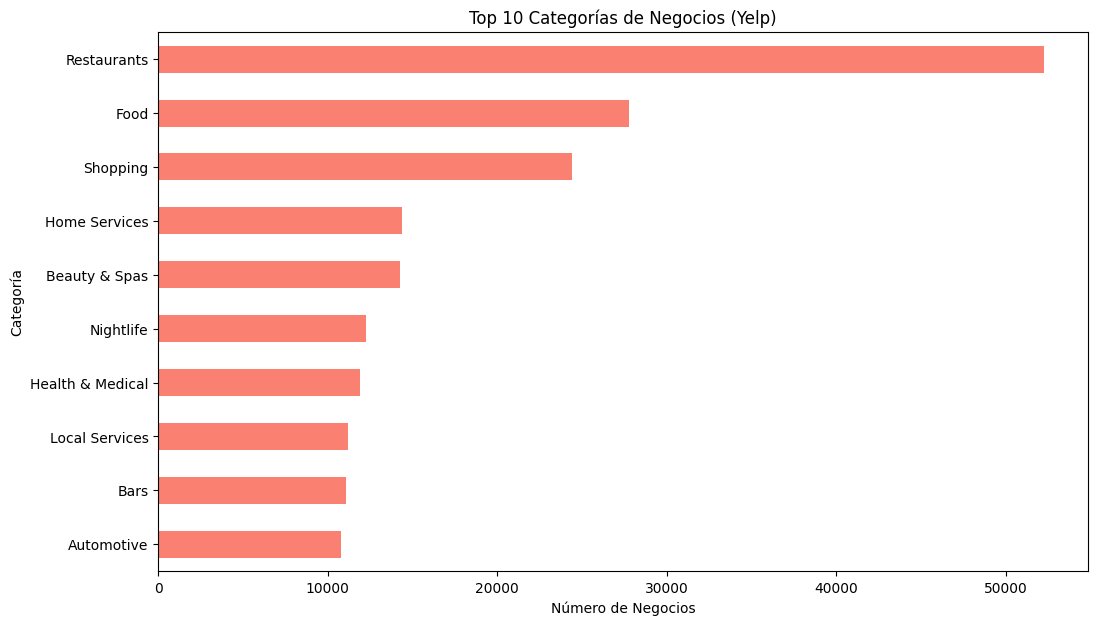

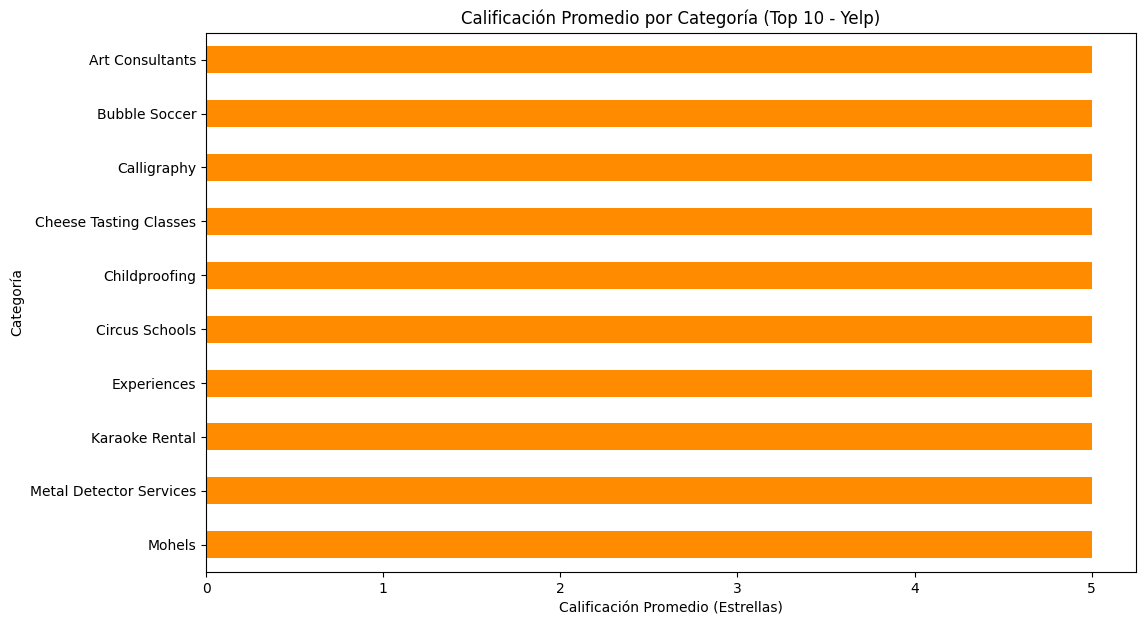

In [41]:
# Ejemplo de unión: yelp_business con yelp_category_rel y yelp_category
# Para ver las categorías de los negocios
query_yelp_business_categories = f"""
SELECT
    yb.name,
    yb.stars,
    yc.category_name
FROM
    `datawave-proyecto-final.yelpdataset.yelp_business` AS yb
JOIN
    `datawave-proyecto-final.yelpdataset.yelp_category_rel` AS ycr ON yb.business_id = ycr.business_id
JOIN
    `datawave-proyecto-final.yelpdataset.yelp_category` AS yc ON ycr.category_id = yc.category_id
LIMIT {QUERY_LIMIT}
"""
yelp_business_categories_df = client_us.query(query_yelp_business_categories).to_dataframe()

print("\n--- yelp_business_categories_df (Ejemplo de JOIN) ---")
print(yelp_business_categories_df.head())
print(yelp_business_categories_df.info())

# Top 10 categorías de negocios
plt.figure(figsize=(12, 7))
yelp_business_categories_df['category_name'].value_counts().head(10).plot(kind='barh', color='salmon')
plt.title('Top 10 Categorías de Negocios (Yelp)')
plt.xlabel('Número de Negocios')
plt.ylabel('Categoría')
plt.gca().invert_yaxis()
plt.show()

# Calificación promedio por categoría (Top 10)
avg_stars_by_category = yelp_business_categories_df.groupby('category_name')['stars'].mean().nlargest(10)
plt.figure(figsize=(12, 7))
avg_stars_by_category.plot(kind='barh', color='darkorange')
plt.title('Calificación Promedio por Categoría (Top 10 - Yelp)')
plt.xlabel('Calificación Promedio (Estrellas)')
plt.ylabel('Categoría')
plt.gca().invert_yaxis()
plt.show()

---

## 3. Ingeniería de Features (Basada en el EDA)

Una vez que hayamos completado el EDA, podremos identificar oportunidades para crear nuevas features que mejoren el poder predictivo de nuestro modelo. Aquí hay algunas ideas, que se confirmarán o ajustarán con base en lo que revele el EDA detallado:

* **Desde `census_df`**:
    * Podríamos agregar **`median_household_income`**, **`median_home_value`** y **`total_population`** a los datos de negocios de Google Maps o Yelp si podemos mapear los negocios a los condados.
* **Desde `gmap_sites_df` y `yelp_business_df`**:
    * **Ratio de Reseñas por Calificación Máxima**: `num_of_reviews` / `max_reviews_in_category` (normalización).
    * **Antigüedad del Negocio**: Si hay una fecha de apertura disponible o se puede inferir del primer registro de reseña.
* **Desde `review_gmap_df` y `review_yelp_df`**:
    * **Sentimiento de Reseñas**: Derivar una puntuación de sentimiento (requiere procesamiento de lenguaje natural) del **`text`**.
    * **Votos por Reseña (Yelp)**: Ratios como `useful` / `text_length` o `useful` / `total_votes`.
    * **Variabilidad de Calificaciones**: Desviación estándar de las calificaciones de las reseñas para un negocio.
    * **Frecuencia de Reseñas**: Número de reseñas por mes/año para un negocio.
* **Desde atributos y categorías (Google Maps y Yelp)**:
    * **Variables Dummies/One-Hot Encoding**: Convertir atributos categóricos importantes (e.g., 'Tiene Wi-Fi', 'Acepta Reservas') en columnas binarias (0 o 1).
    * **Conteo de Atributos**: Número total de atributos que tiene un negocio.
    * **Calificación Promedio por Categoría**: Unir esta métrica a cada negocio.

---

## 4. Selección de Features

La **selección de features** es crucial para construir un modelo eficiente y robusto. Basaremos nuestra selección en el EDA, priorizando las features que muestren la mayor relación con nuestra variable objetivo.

**Criterios de Selección:**

1.  **Relevancia con la Variable Objetivo**: Features que muestren una fuerte correlación (para variables numéricas) o una clara diferencia de distribución (para variables categóricas) con la variable que queremos predecir (e.g., calificación alta, negocio exitoso/abierto).
2.  **Menos Valores Nulos**: Preferiremos features con menos valores nulos, o aquellos que podamos imputar de manera confiable.
3.  **Baja Redundancia/Multicolinealidad**: Evitaremos incluir features altamente correlacionadas entre sí (e.g., si `median_household_income` y `median_home_value` son casi idénticas, podríamos elegir una).
4.  **Variabilidad**: Features con poca variabilidad (e.g., una columna que es casi siempre el mismo valor) aportan poco al modelo.
5.  **Interpretación y Conocimiento del Dominio**: Features que tienen un sentido lógico en el contexto del negocio o la demografía.

**Features Candidatas (Ejemplos, basadas en el EDA previo):**

* **Numéricas**:
    * `avg_rating` (GMaps) / `stars` (Yelp)
    * `num_of_reviews` (GMaps) / `review_count` (Yelp)
    * `median_household_income` (Censo)
    * `median_home_value` (Censo)
    * `total_population` (Censo)
    * `text_length` (reseñas)
    * `useful`, `funny`, `cool` (Yelp reviews)
    * Features de Ingeniería: `review_velocity`, `rating_deviation_from_category_mean`.
* **Categóricas (después de One-Hot Encoding)**:
    * `category_name` (las top N categorías más relevantes)
    * `attribute_name` (los atributos más comunes e impactantes, e.g., 'Has Wi-Fi', 'OutdoorSeating', 'RestaurantsReservations').
* **Identificadores**: `gmap_id`, `business_id` (útiles para uniones pero no para el modelo directamente).
* **Variables de Texto**: El texto crudo de las reseñas (`text`) no se usaría directamente, sino features derivadas de él (sentimiento, palabras clave, etc.).

---

## 5. Fundamentación de la Elección del Modelo y Criterios de Desarrollo

### 5.1. Definición del Problema y Variable Objetivo

Basado en el EDA, es probable que tengamos dos tipos de problemas principales en mente:

1.  **Clasificación**: Predecir si un negocio es **"exitoso"** (e.g., top 25% por calificación y reseñas) o no.
2.  **Regresión**: Predecir la **calificación promedio** de un negocio (`avg_rating` / `stars`).

Vamos a asumir un problema de **Clasificación**: **Predecir si un negocio es exitoso**. El "éxito" se podría definir como:
* Calificación promedio $\geq$ 4.0 y `num_of_reviews` $\geq$ 50 (esto se ajustaría después del EDA).

### 5.2. Justificación de la Elección del Modelo

Dadas las características de nuestros datos (mezcla de features numéricas y categóricas, posibles relaciones no lineales, volumen considerable de datos):

* **Modelos Basados en Árboles (Gradient Boosting, Random Forest)**:
    * **Ventajas**: Son muy robustos, manejan bien la interacción entre features, no requieren escalado de features, son excelentes para datos con relaciones no lineales, y funcionan bien con datos tabulares. Son menos sensibles a outliers que los modelos lineales. **XGBoost** o **LightGBM** son opciones particularmente buenas por su eficiencia y rendimiento.
    * **Justificación basada en EDA**: El EDA probablemente revelará que la relación entre, por ejemplo, el `ingreso_medio_hogar` y la `calificación_promedio` de un negocio no es puramente lineal, sino que hay puntos de quiebre o interacciones complejas con otras features como las categorías o atributos. Los modelos basados en árboles son ideales para capturar estas complejidades. Además, la naturaleza de las categorías y atributos (muchas features categóricas) se maneja bien con estos modelos tras una codificación adecuada (e.g., One-Hot Encoding).

* **Alternativas (si el EDA mostrara otras cosas):**
    * **Regresión Logística/Lineal**: Si el EDA mostrara relaciones predominantemente lineales y la interpretabilidad fuera la máxima prioridad.
    * **Redes Neuronales**: Si el volumen de datos fuera masivo y las relaciones extremadamente complejas, especialmente si el procesamiento avanzado de texto (NLP) de las reseñas fuera un componente central del modelo.

**Nuestra elección preferida sería un algoritmo de Gradient Boosting (como XGBoost o LightGBM).**

### 5.3. Criterios para el Desarrollo del Modelo

Basados en el EDA y la selección de features, los criterios para el desarrollo del modelo incluirán:

1.  **Preprocesamiento de Datos**:
    * **Manejo de Valores Nulos**: Imputación de columnas numéricas con la media/mediana o eliminación de filas/columnas según el porcentaje de nulos.
    * **Codificación de Variables Categóricas**: Uso de One-Hot Encoding para las features categóricas nominales (e.g., `category_name`, `attribute_name`).
    * **Escalado de Features Numéricas**: Aunque los modelos basados en árboles no lo exigen estrictamente, puede ser útil para algunos pasos de ingeniería de features o si se prueban otros modelos.
    * **Transformación de Features Sesgadas**: Aplicar transformaciones logarítmicas a features como `num_of_reviews` o `total_population` si su distribución es muy asimétrica.

2.  **Preparación del Conjunto de Datos**:
    * **Integración de Datos**: Si es posible, unificar las features relevantes de los datasets de Census, Google Maps y Yelp en un único DataFrame maestro utilizando `county_fips` o coordenadas geográficas para el mapeo.
    * **División de Datos**: Dividir el conjunto de datos en conjuntos de **entrenamiento**, **validación** y **prueba** (e.g., 70-15-15% o 80-20%). La división se realizará de manera estratificada si la variable objetivo está desbalanceada.

3.  **Evaluación del Modelo**:
    * **Métricas para Clasificación**:
        * **Recall y Precision**: Para evaluar la capacidad del modelo para identificar correctamente los negocios "exitosos" o "no exitosos", especialmente si hay un desbalance de clases.
        * **F1-Score**: La media armónica de precisión y recall, útil para problemas con clases desbalanceadas.
        * **Curva ROC-AUC**: Para evaluar el rendimiento general del clasificador en diferentes umbrales.
        * **Accuracy**: Se considerará, pero no será la métrica principal si hay un desbalance de clases significativo.
    * **Validación Cruzada (Cross-Validation)**: Utilizaremos K-Fold Cross-Validation para asegurar que la evaluación del rendimiento del modelo sea robusta y no dependa de una única división de datos.

4.  **Optimización del Modelo**:
    * **Ajuste de Hiperparámetros**: Utilizaremos técnicas como `GridSearchCV` o `RandomizedSearchCV` para encontrar la mejor combinación de hiperparámetros para el modelo elegido.
    * **Manejo del Desbalance de Clases**: Si la clase "éxito" está subrepresentada, consideraremos técnicas como `SMOTE` (Synthetic Minority Over-sampling Technique) para el sobremuestreo de la clase minoritaria, o el ajuste de los pesos de clase dentro del algoritmo del modelo.

Con este enfoque estructurado, podrás realizar un análisis de datos completo y construir un modelo robusto y bien justificado.

## Gráfico 1: Condados con mayor densidad poblacional
Este gráfico muestra los condados de mayor densidad de población, calculada como población total dividida por área en millas cuadradas.

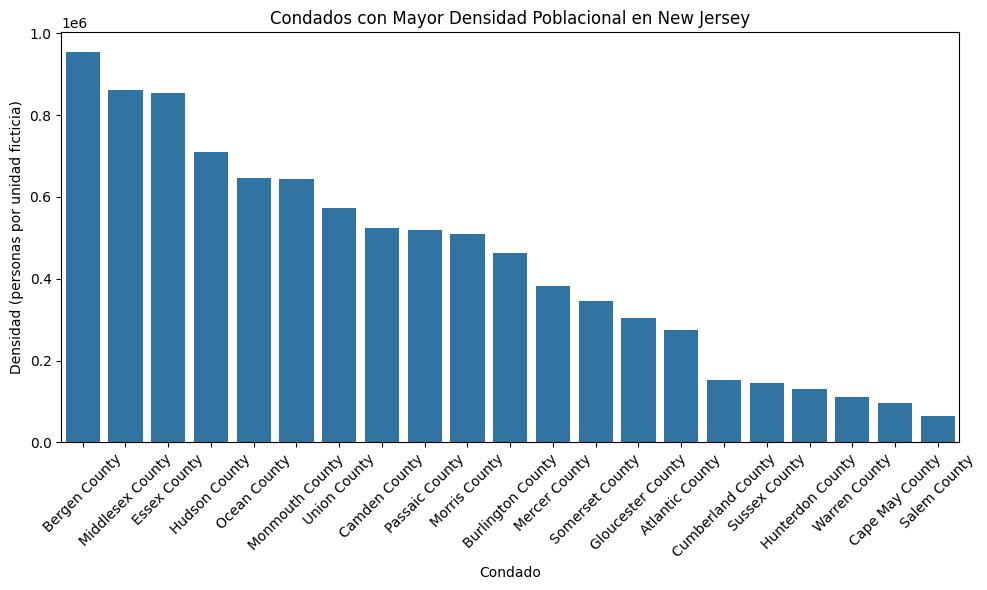

In [42]:
# Calcular densidad antes de usarla
census_df['population_density'] = census_df['total_population'] / 1  # o por área si la tuvieras

# Limpiar el nombre del condado
census_df['clean_county_name'] = census_df['county_name'].str.replace(r',?\s*New Jersey$', '', regex=True)

# Ordenar por densidad
density_counties = census_df.sort_values(by="population_density", ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(data=density_counties, x='clean_county_name', y='population_density')
plt.title('Condados con Mayor Densidad Poblacional en New Jersey')
plt.ylabel('Densidad (personas por unidad ficticia)')
plt.xlabel('Condado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Gráfico 2: Cantidad de reseñas de categoría restaurante por estado (Top 10)
Muestra cuántas reseñas han recibido los restaurantes en los distintos estados.

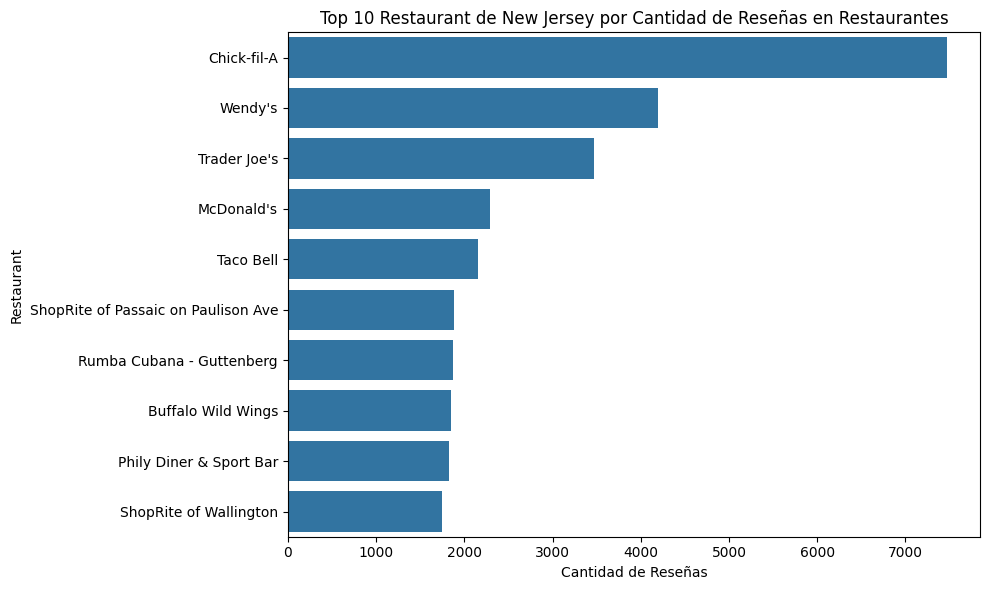

In [43]:
# 1. Definir palabras clave relacionadas a comida
keywords = ['restaurant', 'food', 'bar', 'cafe', 'eatery', 'diner', 'bistro']

# 2. Filtrar gmap_ids donde la categoría esté relacionada
restaurant_ids = gmap_sites_categories_df[
    gmap_sites_categories_df['category_name'].str.lower().str.contains('|'.join(keywords), na=False)
]['gmap_id'].unique()

# 3. Extraer ciudad desde la dirección (antes de la primera coma)
gmap_sites_df['city'] = gmap_sites_df['address'].str.extract(r'^([^,]+)', expand=False)

# 4. Crear un mapa de gmap_id a ciudad
city_map = gmap_sites_df.set_index('gmap_id')['city'].to_dict()
# 5. Filtrar reviews y asignar ciudad a cada una
restaurant_reviews = review_gmap_df[review_gmap_df['gmap_id'].isin(restaurant_ids)].copy()
restaurant_reviews['city'] = restaurant_reviews['gmap_id'].map(city_map)

# 6. Agrupar y graficar por ciudad
reviews_by_city = restaurant_reviews.groupby('city').size().sort_values(ascending=False).head(10)

# 7. Graficar
plt.figure(figsize=(10,6))
sns.barplot(x=reviews_by_city.values, y=reviews_by_city.index)
plt.title('Top 10 Restaurant de New Jersey por Cantidad de Reseñas en Restaurantes')
plt.xlabel('Cantidad de Reseñas')
plt.ylabel('Restaurant')
plt.tight_layout()
plt.show()

## Gráfico 3: Distribución del Ingreso Medio por Hogar
Esta distribución permite entender la riqueza relativa de los condados.

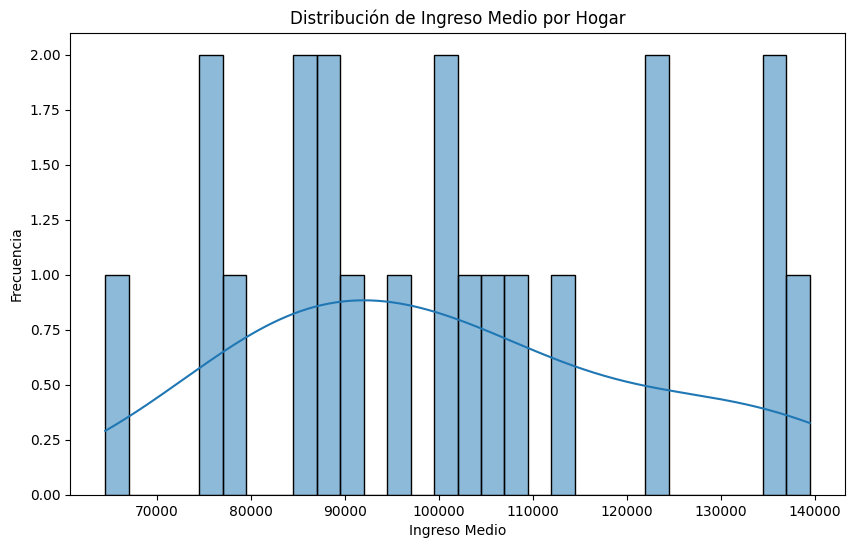

In [44]:
# Usamos census_df con columna 'median_household_income'
plt.figure(figsize=(10,6))
sns.histplot(census_df['median_household_income'], bins=30, kde=True)
plt.title('Distribución de Ingreso Medio por Hogar')
plt.xlabel('Ingreso Medio')
plt.ylabel('Frecuencia')
plt.show()

## Gráfico 4: Densidad de Reseñas
Este gráfico muestra la relación entre la cantidad de reseñas y la cantidad de restaurantes por estado.

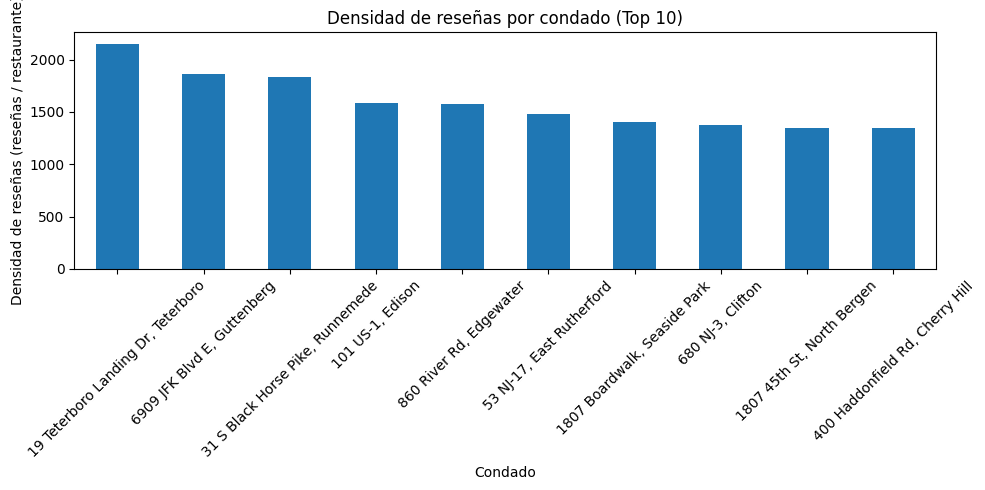

In [45]:
# Extraer el condado de la dirección
gmap_sites_df['county'] = gmap_sites_df['address'].str.extract(r',\s*(.*?)\s*,\s*NJ\s+\d{5},\s*United States')

# Repetir proceso de filtrado y merge, pero usando 'county'
restaurant_ids = gmap_sites_categories_df[
    gmap_sites_categories_df['category_name'].str.lower().str.contains('restaurant')
]['gmap_id'].unique()

restaurant_data = gmap_sites_df[gmap_sites_df['gmap_id'].isin(restaurant_ids)].copy()
restaurant_reviews = review_gmap_df[review_gmap_df['gmap_id'].isin(restaurant_ids)].copy()

# Agregar columna 'county' a los reviews usando merge
restaurant_reviews = restaurant_reviews.merge(
    gmap_sites_df[['gmap_id', 'county']],
    on='gmap_id',
    how='left'
)

# Asegurar que ambas tengan la columna 'county' sin nulos
restaurant_reviews = restaurant_reviews.dropna(subset=['county'])
restaurant_data = restaurant_data.dropna(subset=['county'])

# Agrupar por county
reviews_per_county = restaurant_reviews.groupby('county').size()
restaurants_per_county = restaurant_data.groupby('county').size()

# Calcular densidad de reseñas por restaurante
density_reviews = (reviews_per_county / restaurants_per_county).dropna().sort_values(ascending=False)

import matplotlib.pyplot as plt

if not density_reviews.empty:
    density_reviews.head(10).plot(kind='bar', figsize=(10, 5), title='Densidad de reseñas por condado (Top 10)')
    plt.ylabel('Densidad de reseñas (reseñas / restaurante)')
    plt.xlabel('Condado')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos suficientes para calcular la densidad de reseñas.")


## Gráfico 5: Evolución de la Cantidad de Reseñas en el Tiempo
Permite analizar tendencias en el uso de la plataforma a lo largo del tiempo.

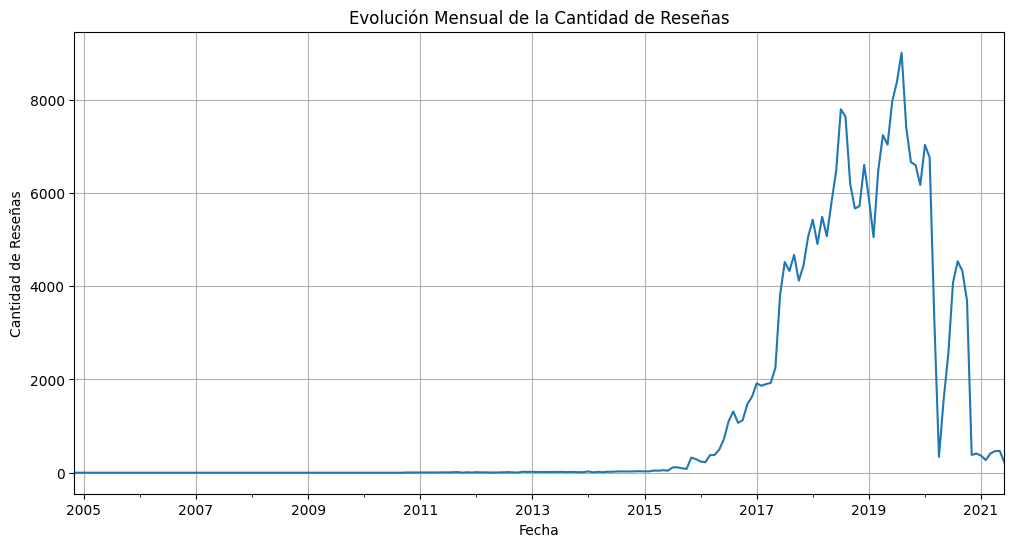

In [46]:
# Usamos review_gmap_df con columna 'date'
review_gmap_df['date'] = pd.to_datetime(review_gmap_df['date'])
monthly_reviews = review_gmap_df.set_index('date').resample('ME').size()

plt.figure(figsize=(12,6))
monthly_reviews.plot()
plt.title('Evolución Mensual de la Cantidad de Reseñas')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Reseñas')
plt.grid(True)
plt.show()

## Gráfico 6: Evolución de Reseñas Positivas, Neutrales y Negativas
Muestra cómo ha cambiado la percepción de los usuarios a lo largo del tiempo.

<Figure size 1200x600 with 0 Axes>

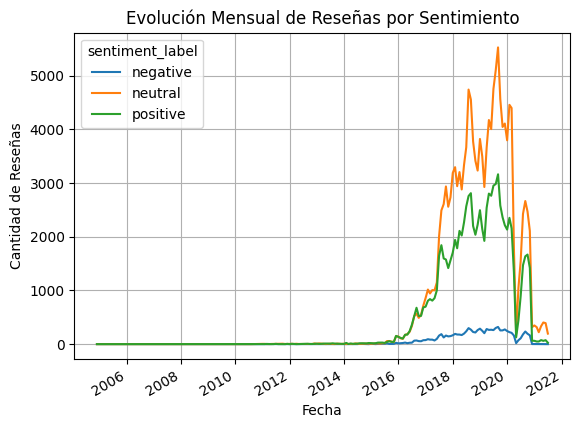

In [47]:
# Asumiendo columna 'sentiment_label' en review_gmap_df ['positive', 'neutral', 'negative']
review_gmap_df['date'] = pd.to_datetime(review_gmap_df['date'])
sentiment_monthly = review_gmap_df.groupby([pd.Grouper(key='date', freq='ME'), 'sentiment_label']).size().unstack().fillna(0)

plt.figure(figsize=(12,6))
sentiment_monthly.plot()
plt.title('Evolución Mensual de Reseñas por Sentimiento')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Reseñas')
plt.grid(True)
plt.show()

📊 1. Top 10 Ciudades con más reseñas de restaurantes (Yelp)

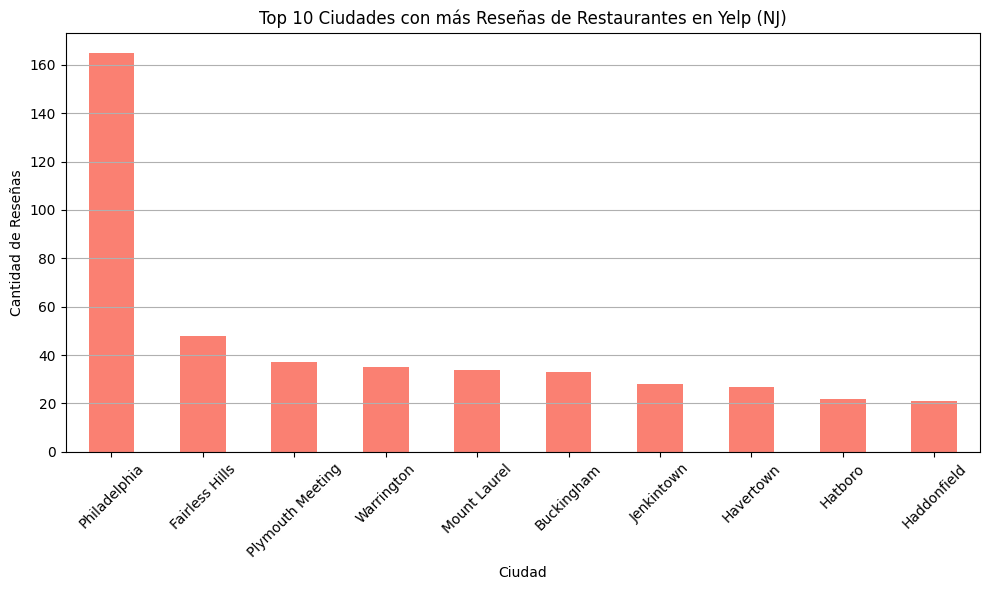

In [48]:
# Filtrar solo los negocios de tipo restaurante
restaurant_ids = yelp_category_rel_df[yelp_category_rel_df['category_id'] == 1]['business_id']

# Filtrar las reseñas correspondientes
restaurant_reviews = review_yelp_df[review_yelp_df['business_id'].isin(restaurant_ids)].copy()

# Agregar columna 'city' desde yelp_business_df
city_map = yelp_business_df.set_index('business_id')['city']
restaurant_reviews['city'] = restaurant_reviews['business_id'].map(city_map)

# Agrupar por ciudad y contar reseñas
top_cities = restaurant_reviews['city'].value_counts().head(10)

# Graficar
plt.figure(figsize=(10,6))
top_cities.plot(kind='bar', color='salmon')
plt.title('Top 10 Ciudades con más Reseñas de Restaurantes en Yelp (NJ)')
plt.ylabel('Cantidad de Reseñas')
plt.xlabel('Ciudad')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


📊 3. Distribución de reseñas por calificación (estrellas)

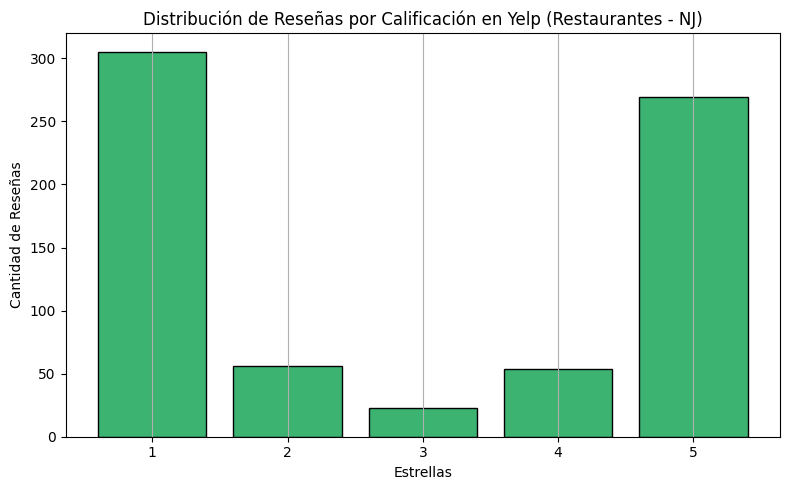

In [49]:
# Histograma de calificaciones de restaurantes (Yelp - NJ)
plt.figure(figsize=(8,5))
restaurant_reviews['stars'].hist(bins=[1, 2, 3, 4, 5, 6], align='left', rwidth=0.8,
                                  color='mediumseagreen', edgecolor='black')

plt.title('Distribución de Reseñas por Calificación en Yelp (Restaurantes - NJ)')
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de Reseñas')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis='y')
plt.tight_layout()
plt.show()


📊 4. Tendencia temporal de reseñas de restaurantes

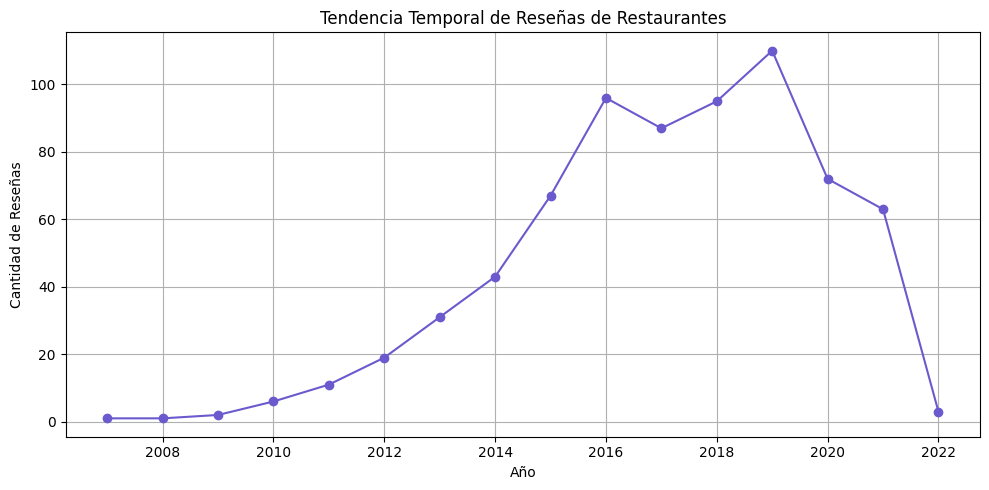

In [50]:
# Agrupar por año
restaurant_reviews['year'] = restaurant_reviews['date'].dt.year
reviews_by_year = restaurant_reviews.groupby('year').size()

# Graficar
plt.figure(figsize=(10,5))
reviews_by_year.plot(marker='o', linestyle='-', color='slateblue')
plt.title('Tendencia Temporal de Reseñas de Restaurantes')
plt.xlabel('Año')
plt.ylabel('Cantidad de Reseñas')
plt.grid(True)
plt.tight_layout()
plt.show()


📊 5. Promedio de estrellas por estado (restaurantes)

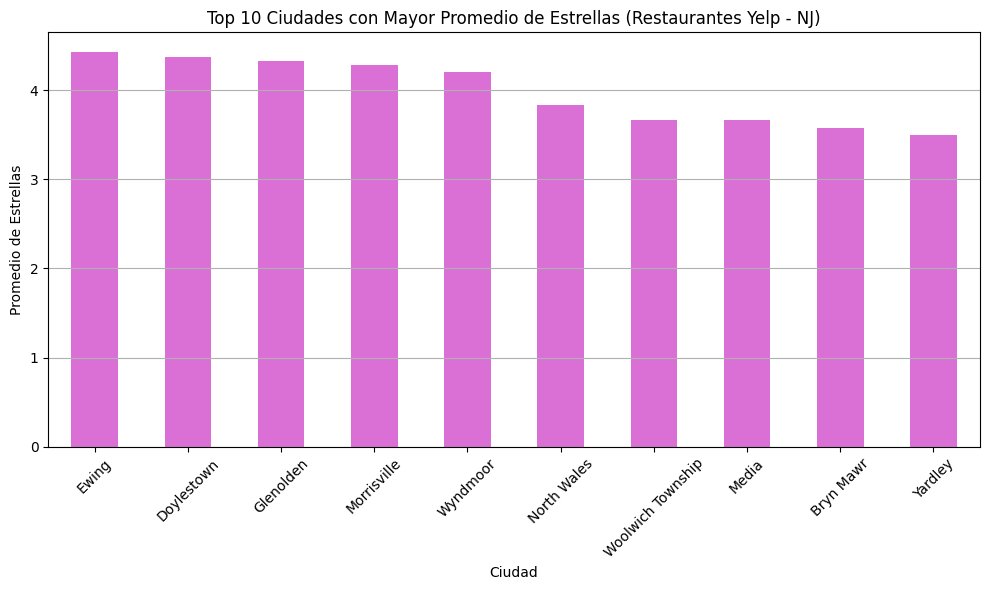

In [51]:
# Asegurar que existe la columna 'city'
city_map = yelp_business_df.set_index('business_id')['city']
restaurant_reviews['city'] = restaurant_reviews['business_id'].map(city_map)

# Agrupar por ciudad y calcular promedio de estrellas
avg_stars_by_city = restaurant_reviews.groupby('city')['stars'].mean().sort_values(ascending=False).head(10)

# Graficar
plt.figure(figsize=(10,6))
avg_stars_by_city.plot(kind='bar', color='orchid')
plt.title('Top 10 Ciudades con Mayor Promedio de Estrellas (Restaurantes Yelp - NJ)')
plt.ylabel('Promedio de Estrellas')
plt.xlabel('Ciudad')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


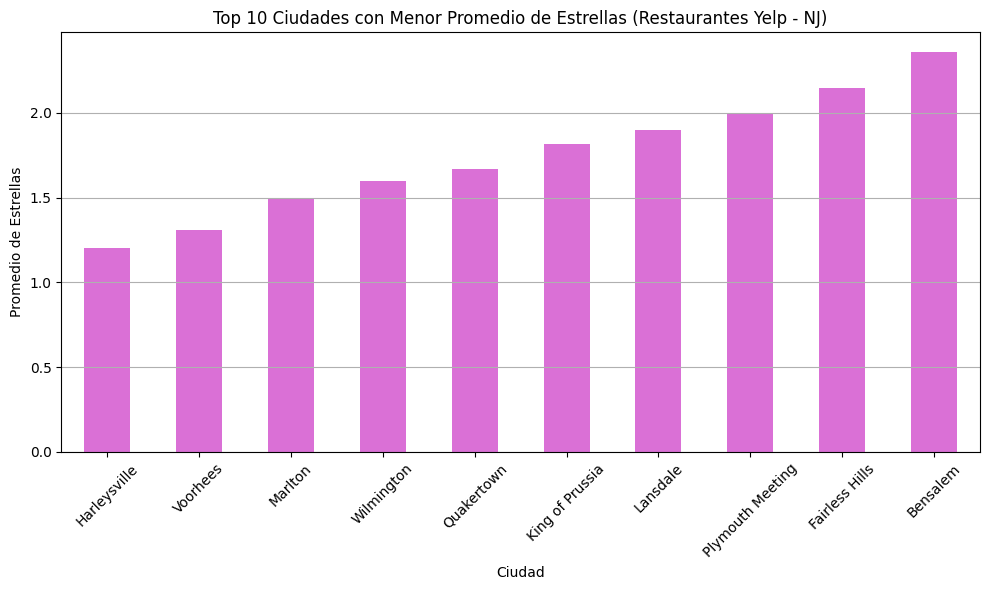

In [52]:
# Asegurar que existe la columna 'city'
city_map = yelp_business_df.set_index('business_id')['city']
restaurant_reviews['city'] = restaurant_reviews['business_id'].map(city_map)

# Agrupar por ciudad y calcular promedio de estrellas
avg_stars_by_city = restaurant_reviews.groupby('city')['stars'].mean().sort_values(ascending=True).head(10)

# Graficar
plt.figure(figsize=(10,6))
avg_stars_by_city.plot(kind='bar', color='orchid')
plt.title('Top 10 Ciudades con Menor Promedio de Estrellas (Restaurantes Yelp - NJ)')
plt.ylabel('Promedio de Estrellas')
plt.xlabel('Ciudad')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Gráfico: Categorías con más reseñas negativas/neutrales en Yelp ---

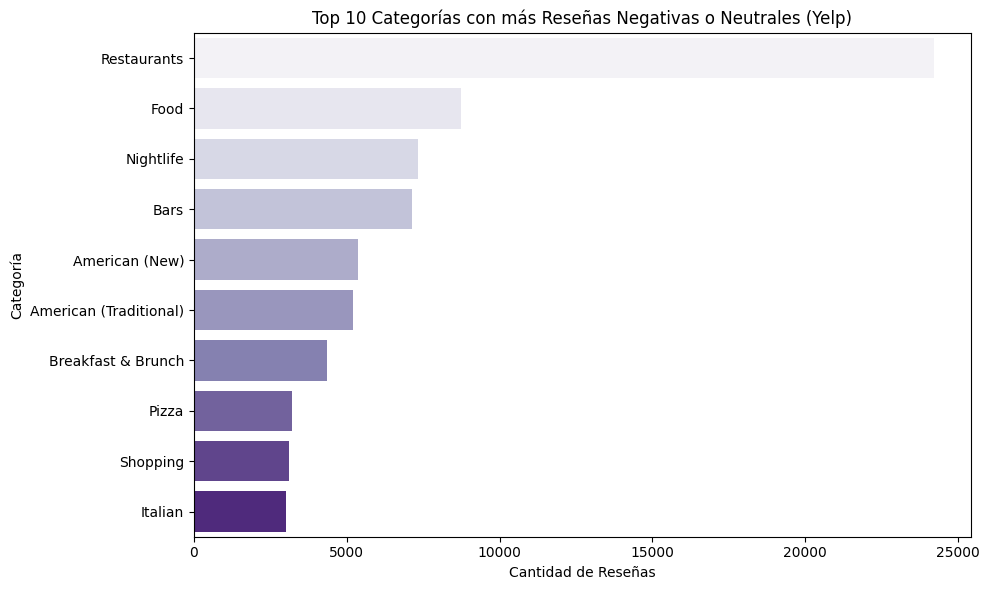

In [61]:
# --- Preparar unión con categorías ---
query_yelp_category = f"""
SELECT *
FROM `datawave-proyecto-final.yelpdataset.yelp_category`
LIMIT {QUERY_LIMIT}
"""
yelp_category_df = client_us.query(query_yelp_category).to_dataframe()

yelp_business_categories_df = yelp_business_df.merge(
    yelp_category_rel_df,
    on='business_id',
    how='left'
).merge(
    yelp_category_df,
    on='category_id',
    how='left'
)[['business_id', 'name', 'stars', 'category_name']]

# --- Gráfico: Categorías con más reseñas negativas/neutrales en Yelp ---

# 1. Filtrar reseñas con puntuación negativa o neutral (<= 3 estrellas)
yelp_neg_neutral_reviews = review_yelp_df[review_yelp_df['stars'] <= 3]

# 2. Unir reseñas con las categorías
yelp_reviews_with_cat = yelp_neg_neutral_reviews.merge(
    yelp_business_categories_df,
    on='business_id',
    how='left'
)

# 3. Contar cuántas reseñas hay por categoría
yelp_cat_counts = yelp_reviews_with_cat['category_name'].value_counts().head(10)

# 4. Graficar
plt.figure(figsize=(10,6))
sns.barplot(
    x=yelp_cat_counts.values,
    y=yelp_cat_counts.index,
    hue=yelp_cat_counts.index,  # Para que palette funcione bien
    palette='Purples',
    dodge=False,
    legend=False
)
plt.title('Top 10 Categorías con más Reseñas Negativas o Neutrales (Yelp)')
plt.xlabel('Cantidad de Reseñas')
plt.ylabel('Categoría')
plt.tight_layout()
plt.show()


# --- Gráfico: Categorías con más reseñas negativas/neutrales en Google Maps ---

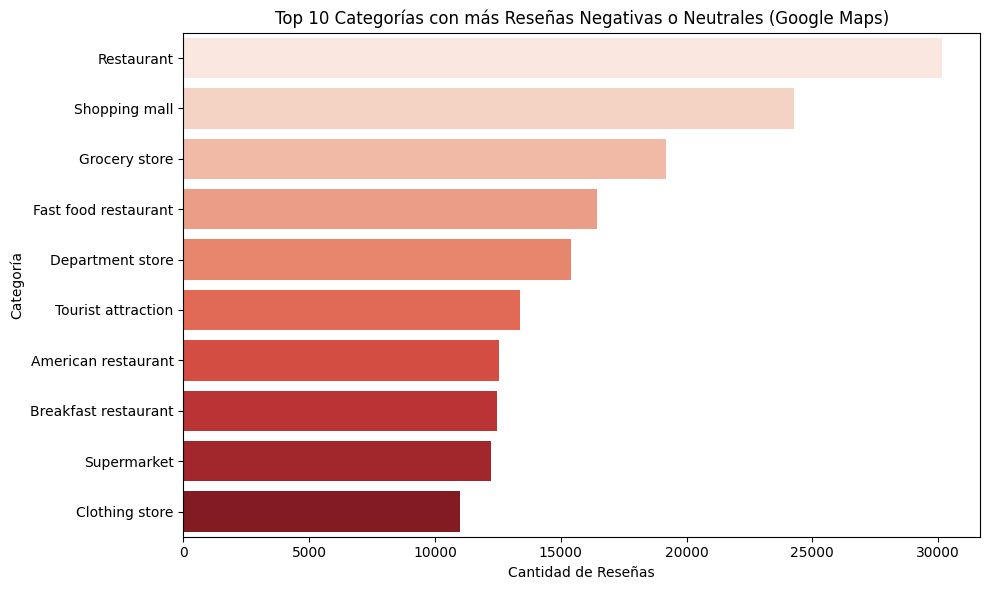

In [64]:
# --- Gráfico: Categorías con más reseñas negativas/neutrales en Google Maps ---

# Filtrar reseñas negativas o neutrales
gmap_neg_neutral_reviews = review_gmap_df[
    review_gmap_df['sentiment_label'].isin(['negative', 'neutral'])
]

# Unir con categorías
gmap_reviews_with_cat = gmap_neg_neutral_reviews.merge(
    gmap_sites_categories_df[['gmap_id', 'category_name']],
    left_on='gmap_id', right_on='gmap_id', how='left'
)

# Contar por categoría
gmap_cat_counts = gmap_reviews_with_cat['category_name'].value_counts().head(10)

# Graficar
plt.figure(figsize=(10,6))
sns.barplot(
    x=gmap_cat_counts.values,
    y=gmap_cat_counts.index,
    hue=gmap_cat_counts.index,  # explícito
    palette='Reds',
    dodge=False,
    legend=False
)
plt.title('Top 10 Categorías con más Reseñas Negativas o Neutrales (Google Maps)')
plt.xlabel('Cantidad de Reseñas')
plt.ylabel('Categoría')
plt.tight_layout()
plt.show()


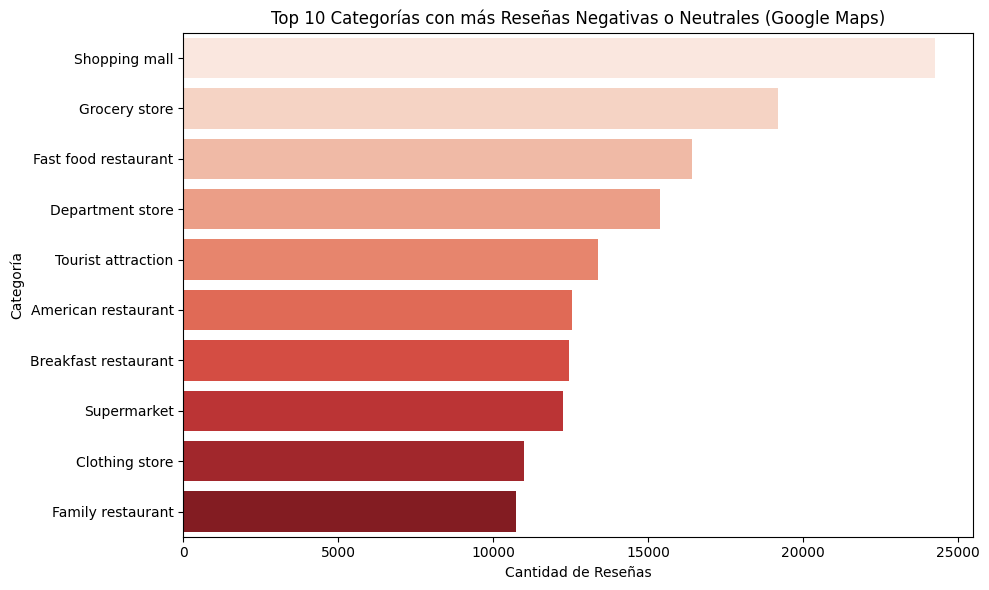

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming review_gmap_df and gmap_sites_categories_df are already defined.
# If not, you'll need to load them first.
# For example:
# review_gmap_df = pd.read_csv('path/to/your/review_gmap_data.csv')
# gmap_sites_categories_df = pd.read_csv('path/to/your/gmap_sites_categories_data.csv')


# Filtrar reseñas negativas o neutrales
gmap_neg_neutral_reviews = review_gmap_df[
    review_gmap_df['sentiment_label'].isin(['negative', 'neutral'])
]

# Unir con categorías
gmap_reviews_with_cat = gmap_neg_neutral_reviews.merge(
    gmap_sites_categories_df[['gmap_id', 'category_name']],
    left_on='gmap_id', right_on='gmap_id', how='left'
)

# Contar por categoría y seleccionar del 2do al 11vo
# .value_counts() ordena de forma descendente por defecto.
# .iloc[1:11] selecciona los elementos desde el índice 1 (el segundo) hasta el 10 (el undécimo).
gmap_cat_counts = gmap_reviews_with_cat['category_name'].value_counts().iloc[1:11]

# Graficar
plt.figure(figsize=(10,6))
sns.barplot(
    x=gmap_cat_counts.values,
    y=gmap_cat_counts.index,
    hue=gmap_cat_counts.index,   # explícito
    palette='Reds',
    dodge=False,
    legend=False
)
plt.title('Top 10 Categorías con más Reseñas Negativas o Neutrales (Google Maps)')
plt.xlabel('Cantidad de Reseñas')
plt.ylabel('Categoría')
plt.tight_layout()
plt.show()